<a href="https://colab.research.google.com/github/jsjj10002/FackVoiceClassfication/blob/main/LFCC_SE%2BResABNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요

### 1단계: 데이터 로딩 및 전처리

- 필요한 라이브러리 임포트
- 10개의 샘플 음성 파일 선택
- 데이터 로딩 함수 구현
- 음성 파일 시각화 (파형 및 스펙트로그램)
- 데이터 증강 기법 구현 (노이즈 추가, 피치 변경, 시간 늘리기/줄이기, 리버스)
- 증강된 데이터 시각화

### 2단계: LFCC 특성 추출

- LFCCExtractor 클래스 구현
- 샘플 데이터에 대한 LFCC 특성 추출
- LFCC 특성 시각화

### 3단계: SE-ResABNet 모델 구현

- SEBlock 구현
- ResidualBlock 구현
- AttentionBranch 구현
- SE_ResABNet 구현
- LFCC_SE_ResABNet 구현
- 모델 구조 시각화

### 4단계: 손실 함수 구현

- CombLoss 클래스 구현
- 각 손실 함수 컴포넌트 테스트

### 5단계: 데이터셋 및 데이터 로더 구현

- AudioDataset 클래스 구현
- 데이터 로더 생성

### 6단계: 학습 및 평가 함수 구현

- train_epoch 함수 구현
- evaluate 함수 구현

### 7단계: TPU 설정 및 메인 학습 루프

- TPU 초기화
- 메인 학습 루프 구현
- 학습 과정 시각화 (손실 및 정확도 그래프)

### 8단계: 테스트 셋에 대한 추론

- 테스트 데이터 로딩
- 학습된 모델을 사용한 추론
- 결과 시각화 및 저장

# 1. 데이터 로딩 및 전처리

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## train셋 레이블 균형 확인

레이블 개수:
label
fake    27818
real    27620
Name: count, dtype: int64

레이블 비율:
label
fake    50.178578
real    49.821422
Name: proportion, dtype: float64



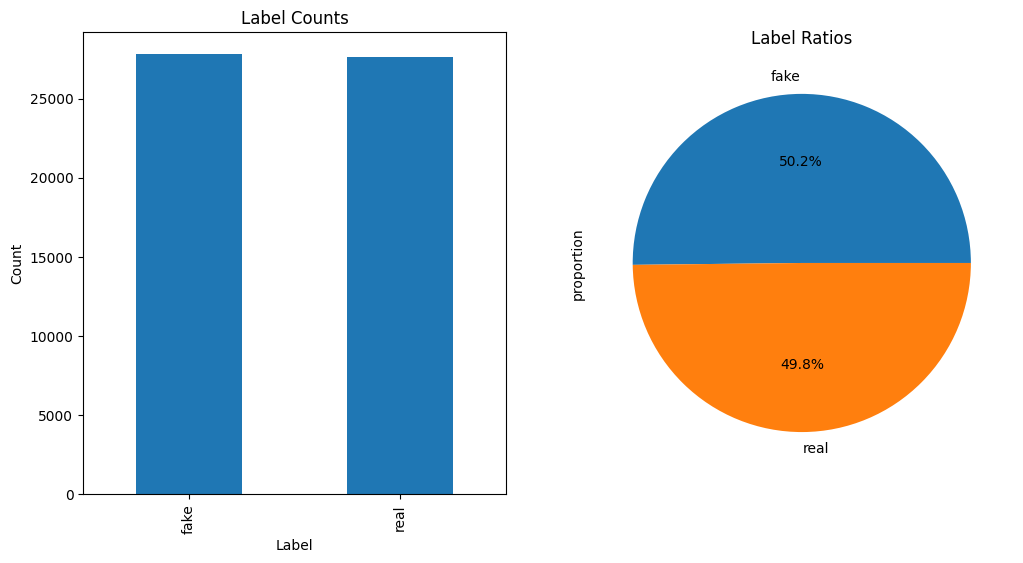

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
file_path = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train.csv'
df = pd.read_csv(file_path)

# 레이블 비율과 개수 계산
label_counts = df['label'].value_counts()
label_ratios = df['label'].value_counts(normalize=True) * 100

# 결과 출력
print(f"레이블 개수:\n{label_counts}\n")
print(f"레이블 비율:\n{label_ratios}\n")

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 개수 시각화
label_counts.plot(kind='bar', ax=ax[0])
ax[0].set_title('Label Counts')
ax[0].set_xlabel('Label')
ax[0].set_ylabel('Count')

# 비율 시각화
label_ratios.plot(kind='pie', autopct='%1.1f%%', ax=ax[1])
ax[1].set_title('Label Ratios')

plt.show()


## 1. 라이브러리 호출

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
import torchaudio
import torch.nn.functional as F
from IPython.display import Audio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.calibration import calibration_curve
from torch.utils.data import DataLoader, random_split
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

## 2. 샘플 데이터 10개 선택

In [ ]:
import os
import pandas as pd
import librosa

# CSV 파일 경로 설정
csv_path = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train.csv'
base_path = os.path.dirname(csv_path)

# CSV 파일 로드
df = pd.read_csv(csv_path)

# 각 클래스(real, fake)에서 5개씩 무작위로 선택
real_samples = df[df['label'] == 'real'].sample(5, random_state=42)
fake_samples = df[df['label'] == 'fake'].sample(5, random_state=42)
samples = pd.concat([real_samples, fake_samples]).reset_index(drop=True)

print(samples)



         id                  path label
0  FXBOIRJD  ./train/FXBOIRJD.ogg  real
1  UFUVJPJJ  ./train/UFUVJPJJ.ogg  real
2  KAUHLOQF  ./train/KAUHLOQF.ogg  real
3  CWCSEJIQ  ./train/CWCSEJIQ.ogg  real
4  VONQSLDE  ./train/VONQSLDE.ogg  real
5  CJBSPRHA  ./train/CJBSPRHA.ogg  fake
6  MHIVJAPA  ./train/MHIVJAPA.ogg  fake
7  HMLTULCO  ./train/HMLTULCO.ogg  fake
8  HOXNWKYN  ./train/HOXNWKYN.ogg  fake
9  LHNHVUFV  ./train/LHNHVUFV.ogg  fake


## 3. 데이터 로딩 함수 정의

In [ ]:
def load_audio(file_path, sr=16000):
    waveform, sample_rate = librosa.load(file_path, sr=sr)
    return waveform, sample_rate

def load_sample_audios(samples, base_path):
    audios = []
    for _, row in samples.iterrows():
        # 올바른 경로 생성
        file_path = os.path.join(base_path, row['path'])
        # 경로 정규화
        file_path = os.path.normpath(file_path)
        try:
            waveform, sr = load_audio(file_path)
            audios.append((waveform, sr, row['label']))
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return audios

sample_audios = load_sample_audios(samples, base_path)

<ipython-input-5-ea4f0207ad0f>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sample_rate = librosa.load(file_path, sr=sr)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


## 4. 음성 파일 시각화(파형, 스펙트럼)

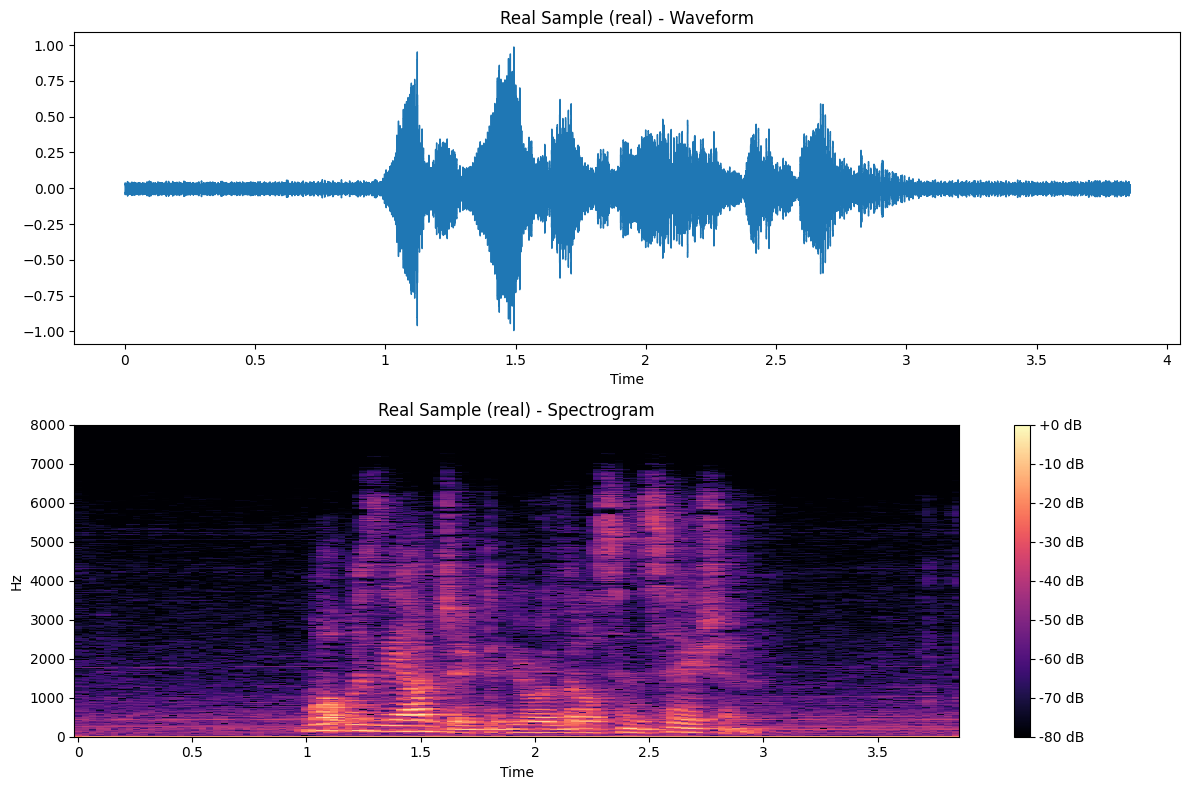

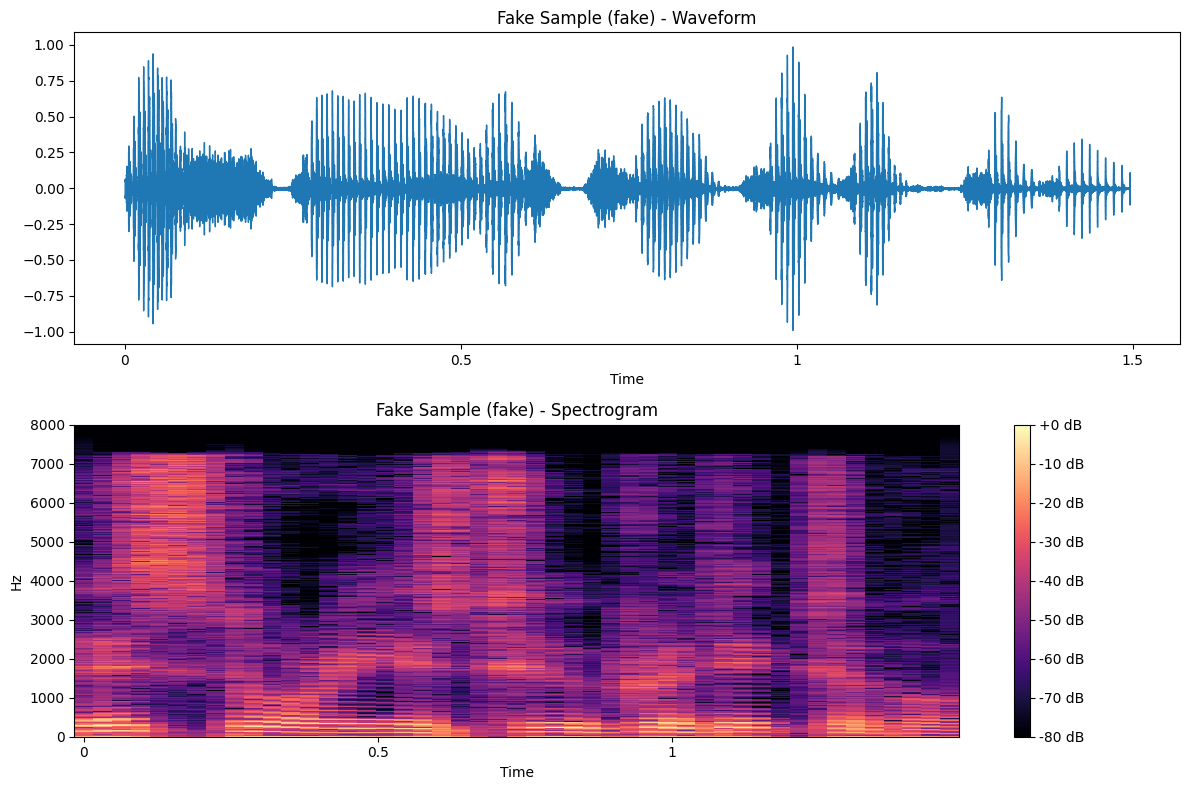

In [ ]:
def plot_waveform_and_spectrogram(waveform, sr, title):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(waveform, sr=sr)
    plt.title(f'{title} - Waveform')

    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(waveform)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{title} - Spectrogram')

    plt.tight_layout()
    plt.show()

# 진짜 샘플 1개, 가짜 샘플 1개 선택
real_sample = next(sample for sample in sample_audios if sample[2] == 'real')
fake_sample = next(sample for sample in sample_audios if sample[2] == 'fake')

# 진짜 샘플 시각화 및 재생
plot_waveform_and_spectrogram(real_sample[0], real_sample[1], f'Real Sample ({real_sample[2]})')
display(Audio(real_sample[0], rate=real_sample[1]))

# 가짜 샘플 시각화 및 재생
plot_waveform_and_spectrogram(fake_sample[0], fake_sample[1], f'Fake Sample ({fake_sample[2]})')
display(Audio(fake_sample[0], rate=fake_sample[1]))

## 5. 데이터 증강 기법

In [ ]:
def add_noise(waveform, noise_factor=0.005):
    noise = np.random.randn(len(waveform))
    augmented_waveform = waveform + noise_factor * noise
    return augmented_waveform

def change_pitch(waveform, sr, n_steps=4):
    return librosa.effects.pitch_shift(waveform, sr=sr, n_steps=n_steps)

def time_stretch(waveform, rate=1.2):
    return librosa.effects.time_stretch(waveform, rate=rate)

def reverse(waveform):
    return waveform[::-1]

def apply_augmentation(waveform, sr):
    augmented_waveforms = [
        ("Original", waveform),
        ("Noisy", add_noise(waveform)),
        ("Pitch Shifted", change_pitch(waveform, sr)),
        ("Time Stretched", time_stretch(waveform)),
        ("Reversed", reverse(waveform))
    ]
    return augmented_waveforms

## 6. 증강 데이터 시각화

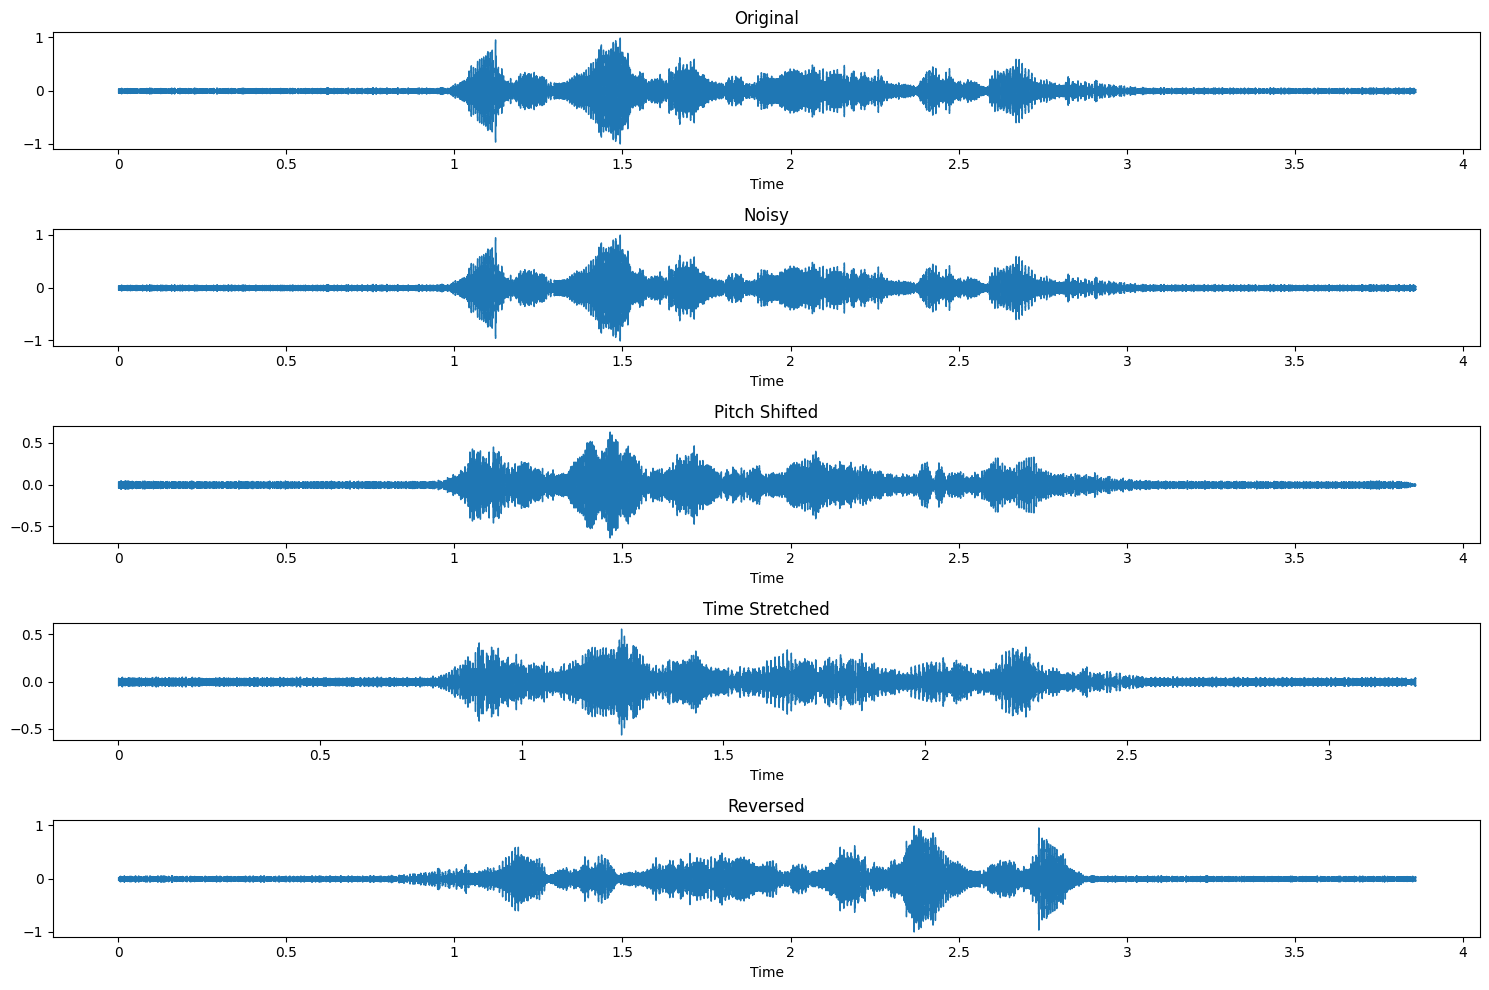

Real Sample Augmentations:
Playing: Original


Playing: Noisy


Playing: Pitch Shifted


Playing: Time Stretched


Playing: Reversed


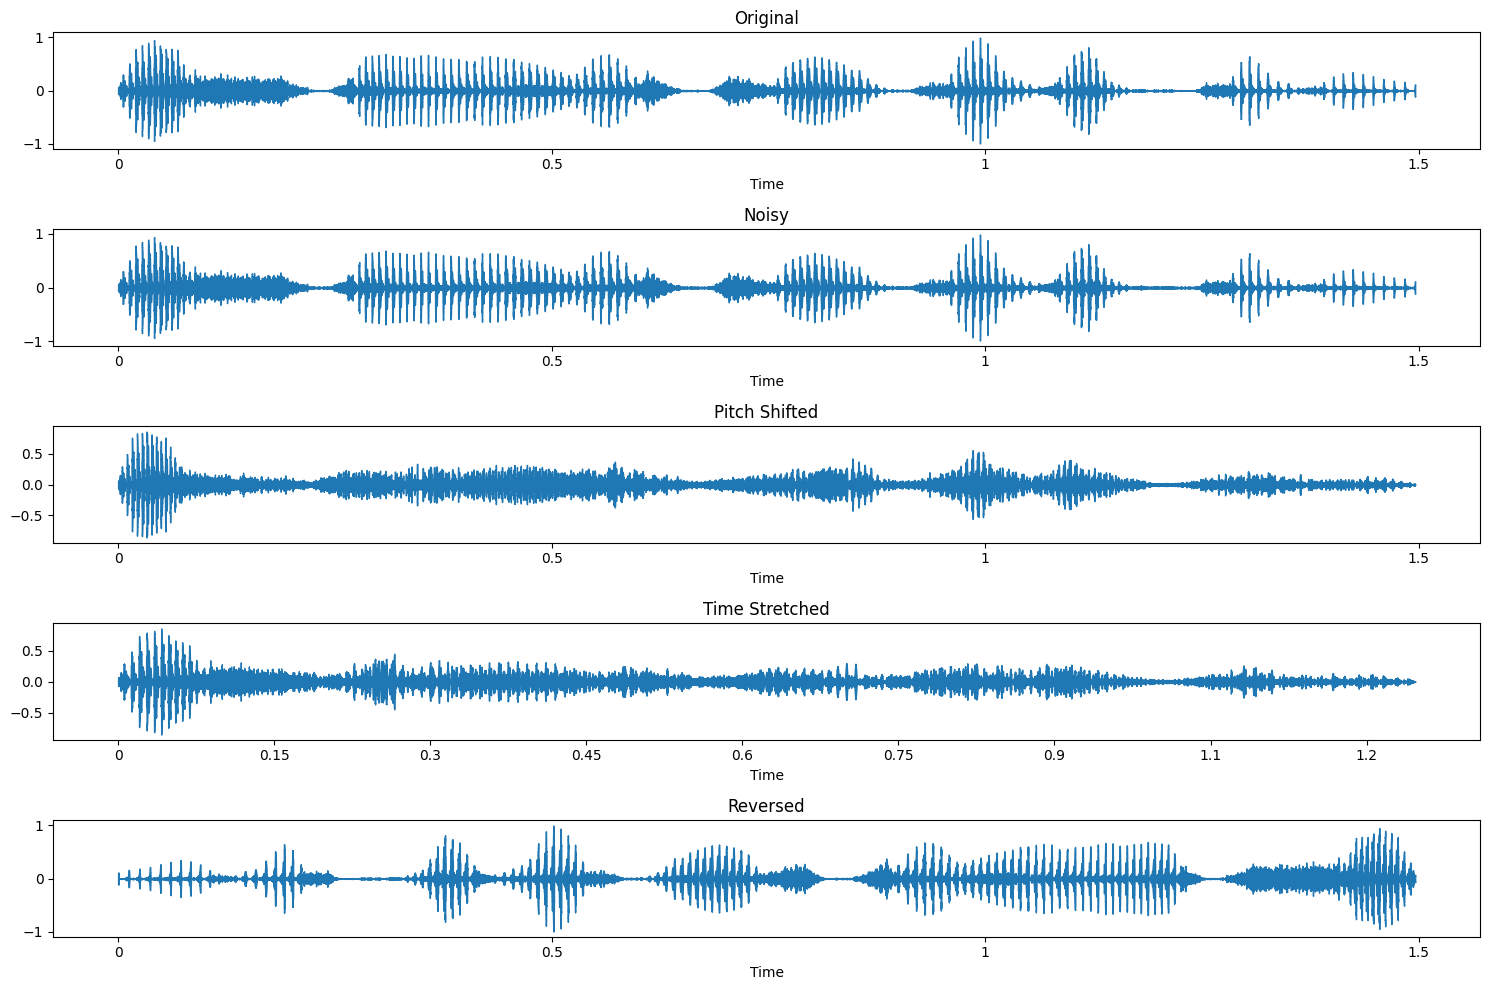

Fake Sample Augmentations:
Playing: Original


Playing: Noisy


Playing: Pitch Shifted


Playing: Time Stretched


Playing: Reversed


In [ ]:
def plot_augmented_waveforms(augmented_waveforms, sr):
    plt.figure(figsize=(15, 10))
    for i, (title, aug_waveform) in enumerate(augmented_waveforms):
        plt.subplot(len(augmented_waveforms), 1, i+1)
        librosa.display.waveshow(aug_waveform, sr=sr)
        plt.title(title)
        plt.tight_layout()
    plt.show()

# 진짜 샘플에 대해 증강 기법 적용 및 시각화
real_augmented_waveforms = apply_augmentation(real_sample[0], real_sample[1])
plot_augmented_waveforms(real_augmented_waveforms, real_sample[1])

print("Real Sample Augmentations:")
for title, aug_waveform in real_augmented_waveforms:
    print(f"Playing: {title}")
    display(Audio(aug_waveform, rate=real_sample[1]))

# 가짜 샘플에 대해 증강 기법 적용 및 시각화
fake_augmented_waveforms = apply_augmentation(fake_sample[0], fake_sample[1])
plot_augmented_waveforms(fake_augmented_waveforms, fake_sample[1])

print("Fake Sample Augmentations:")
for title, aug_waveform in fake_augmented_waveforms:
    print(f"Playing: {title}")
    display(Audio(aug_waveform, rate=fake_sample[1]))

# LFCC 추출

## 1. LFCCExtractor 클래스 구현

In [ ]:
import torch
import torchaudio
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch.nn as nn

class LFCCExtractor(nn.Module):
    def __init__(self, sample_rate=16000, n_lfcc=40, n_frames=1000):
        super(LFCCExtractor, self).__init__()
        self.lfcc = torchaudio.transforms.LFCC(
            sample_rate=sample_rate,
            n_lfcc=n_lfcc,
            speckwargs={'n_fft': 512, 'win_length': 400, 'hop_length': 160}
        )
        self.n_frames = n_frames

    def forward(self, waveform):
        # waveform shape: (batch_size, num_samples)
        lfcc = self.lfcc(waveform)
        # lfcc shape: (batch_size, n_lfcc, time)

        if lfcc.shape[2] > self.n_frames:
            lfcc = lfcc[:, :, :self.n_frames]
        elif lfcc.shape[2] < self.n_frames:
            lfcc = F.pad(lfcc, (0, self.n_frames - lfcc.shape[2]))

        return lfcc.unsqueeze(1)  # shape: (batch_size, 1, 3*n_lfcc, n_frames)

    def _adjust_time_dimension(self, feature):
        if feature.shape[2] > self.n_frames:
            feature = feature[:, :, :self.n_frames]
        elif feature.shape[2] < self.n_frames:
            feature = F.pad(feature, (0, self.n_frames - feature.shape[2]))
        return feature

In [ ]:
class LFCCExtractorTest(torch.nn.Module):
    def __init__(self, sample_rate=16000, n_lfcc=40, n_frames=200):
        super(LFCCExtractorTest, self).__init__()
        self.lfcc = torchaudio.transforms.LFCC(
            sample_rate=sample_rate,
            n_lfcc=n_lfcc,
            speckwargs={'n_fft': 512, 'win_length': 400, 'hop_length': 160}
        )
        self.n_frames = n_frames

    def pre_emphasis(self, waveform, coeff=0.97):
        return torch.cat((waveform[:, :1], waveform[:, 1:] - coeff * waveform[:, :-1]), dim=1)

    def forward(self, waveform):
        waveform = self.pre_emphasis(waveform)
        lfcc = self.lfcc(waveform)
        if lfcc.shape[2] > self.n_frames:
            lfcc = lfcc[:, :, :self.n_frames]
        elif lfcc.shape[2] < self.n_frames:
            lfcc = F.pad(lfcc, (0, self.n_frames - lfcc.shape[2]))
        delta = torchaudio.functional.compute_deltas(lfcc)
        double_delta = torchaudio.functional.compute_deltas(delta)
        return lfcc, delta, double_delta


## 2. 샘플 데이터 LFCC 특징 추출

In [ ]:
def extract_lfcc(waveform, sr):
    extractor = LFCCExtractorTest(sample_rate=sr)
    waveform_tensor = torch.tensor(waveform).unsqueeze(0)
    lfcc, delta, double_delta = extractor(waveform_tensor)
    return lfcc.squeeze(0).numpy(), delta.squeeze(0).numpy(), double_delta.squeeze(0).numpy()

# LFCC 추출
real_lfcc, real_delta, real_double_delta = extract_lfcc(real_sample[0], real_sample[1])
fake_lfcc, fake_delta, fake_double_delta = extract_lfcc(fake_sample[0], fake_sample[1])

## 3. LFCC 특징 시각화

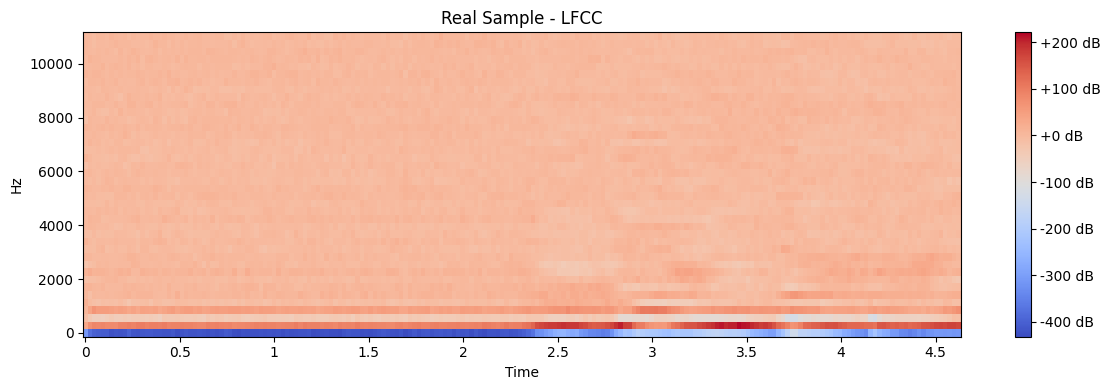

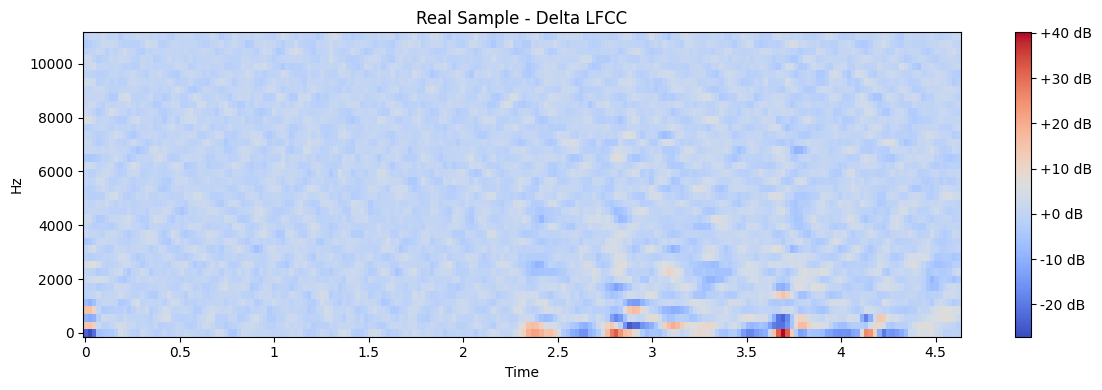

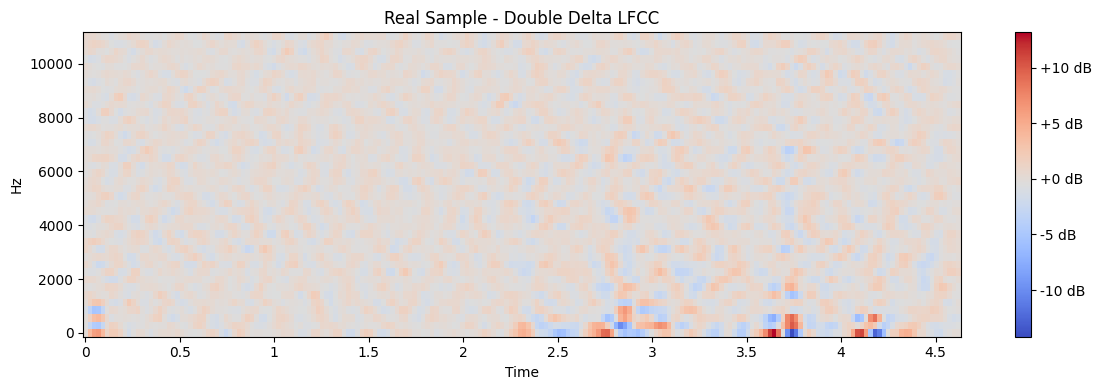

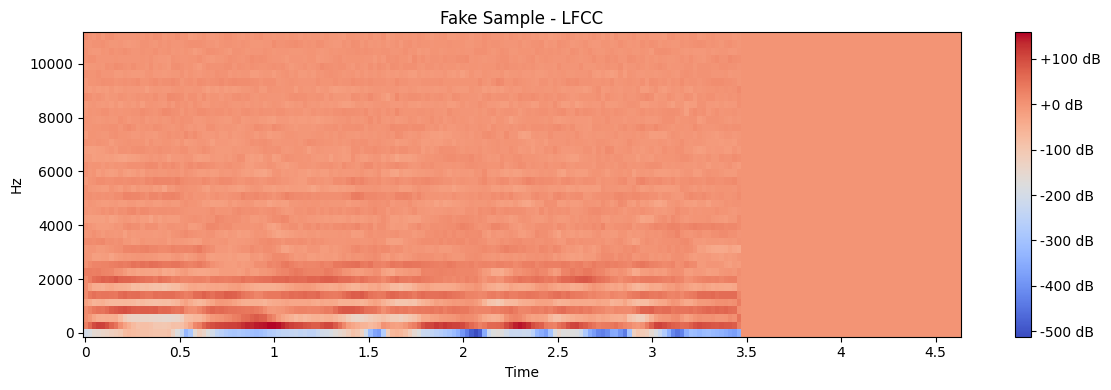

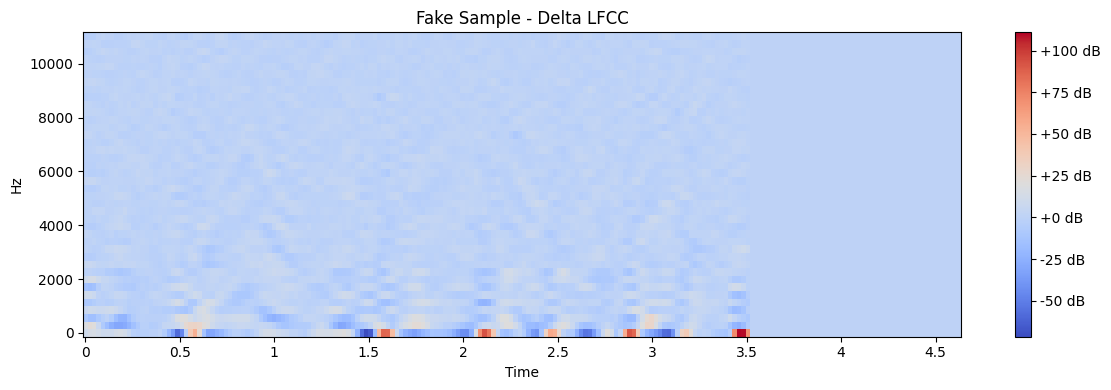

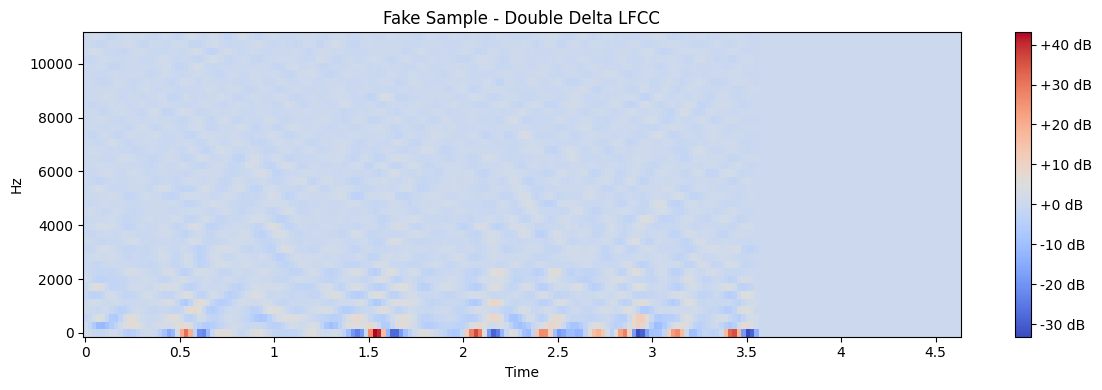

In [ ]:
# 시각화 함수
def plot_features(feature, title):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(feature, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# LFCC, Delta, Double Delta 시각화
plot_features(real_lfcc, 'Real Sample - LFCC')
plot_features(real_delta, 'Real Sample - Delta LFCC')
plot_features(real_double_delta, 'Real Sample - Double Delta LFCC')

plot_features(fake_lfcc, 'Fake Sample - LFCC')
plot_features(fake_delta, 'Fake Sample - Delta LFCC')
plot_features(fake_double_delta, 'Fake Sample - Double Delta LFCC')

## 4. LFCC 특징 통계분석

In [ ]:
# 통계 분석 함수
def analyze_features(feature, title):
    print(f"{title} Statistics:")
    print(f"Shape: {feature.shape}")
    print(f"Mean: {np.mean(feature):.4f}")
    print(f"Std: {np.std(feature):.4f}")
    print(f"Min: {np.min(feature):.4f}")
    print(f"Max: {np.max(feature):.4f}")
    print("\n")

# 통계 분석
analyze_features(real_lfcc, "Real Sample LFCC")
analyze_features(real_delta, "Real Sample Delta LFCC")
analyze_features(real_double_delta, "Real Sample Double Delta LFCC")

analyze_features(fake_lfcc, "Fake Sample LFCC")
analyze_features(fake_delta, "Fake Sample Delta LFCC")
analyze_features(fake_double_delta, "Fake Sample Double Delta LFCC")

Real Sample LFCC Statistics:
Shape: (40, 200)
Mean: -5.7147
Std: 60.5524
Min: -431.9200
Max: 221.2026


Real Sample Delta LFCC Statistics:
Shape: (40, 200)
Mean: 0.0164
Std: 2.8964
Min: -27.1931
Max: 40.1432


Real Sample Double Delta LFCC Statistics:
Shape: (40, 200)
Mean: -0.0001
Std: 1.1297
Min: -14.2031
Max: 13.1939


Fake Sample LFCC Statistics:
Shape: (40, 200)
Mean: -3.7456
Std: 42.0256
Min: -512.1125
Max: 158.4721


Fake Sample Delta LFCC Statistics:
Shape: (40, 200)
Mean: 0.0186
Std: 5.9346
Min: -71.6118
Max: 110.9521


Fake Sample Double Delta LFCC Statistics:
Shape: (40, 200)
Mean: -0.0018
Std: 2.4315
Min: -33.1754
Max: 43.0929




## 5. LFCC 특징 차이 시각화

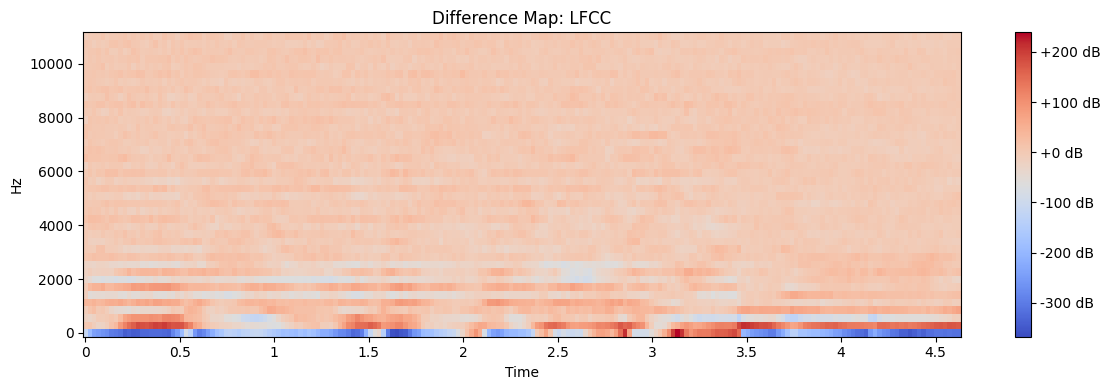

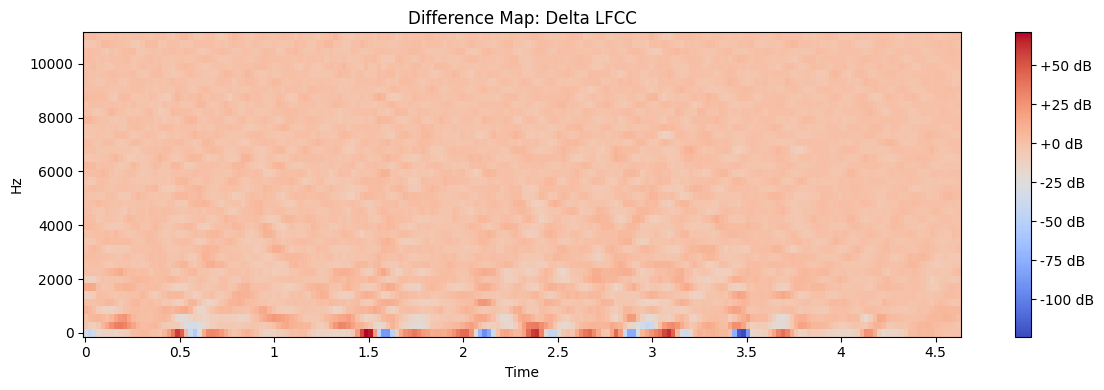

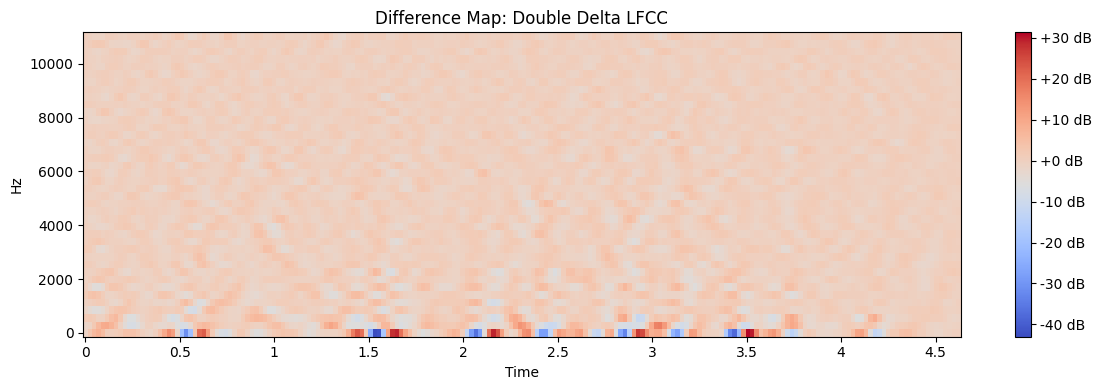

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 1. 차이 맵 시각화
def plot_difference_map(real_feature, fake_feature, title):
    diff = real_feature - fake_feature
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(diff, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Difference Map: {title}')
    plt.tight_layout()
    plt.show()

plot_difference_map(real_lfcc, fake_lfcc, 'LFCC')
plot_difference_map(real_delta, fake_delta, 'Delta LFCC')
plot_difference_map(real_double_delta, fake_double_delta, 'Double Delta LFCC')

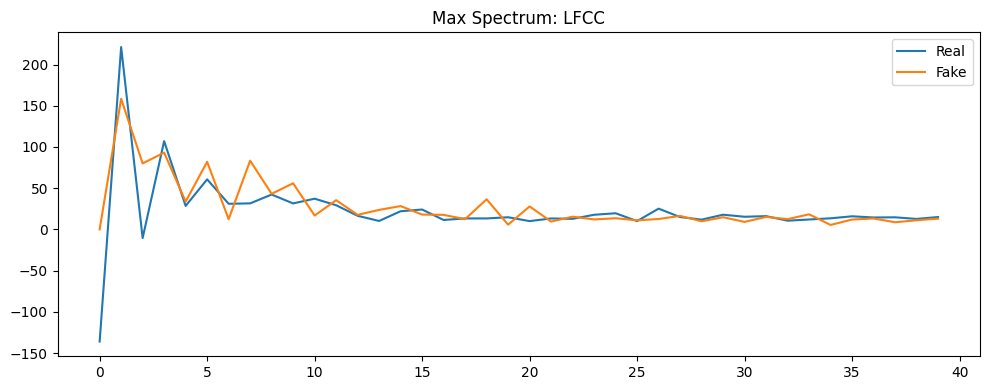

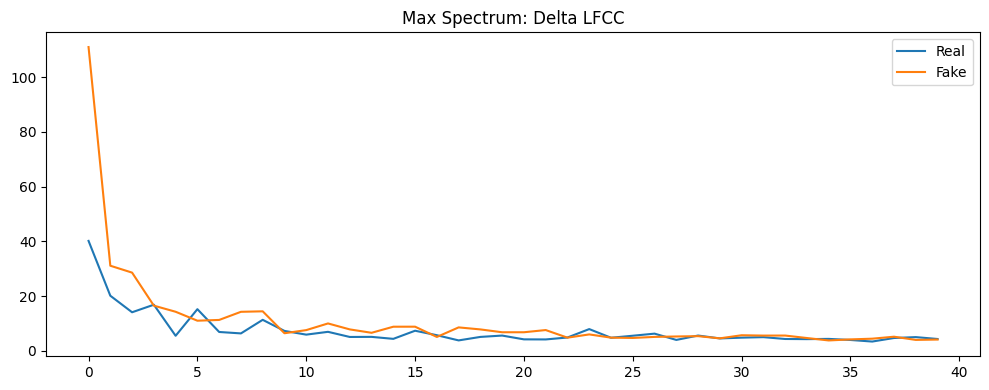

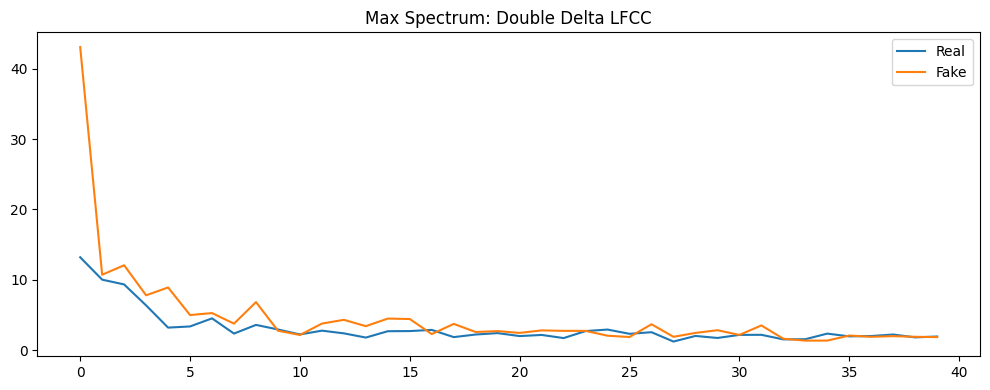

In [ ]:
# 2. 최대값 스펙트럼 비교
def plot_max_spectrum(real_feature, fake_feature, title):
    real_max = np.max(real_feature, axis=1)
    fake_max = np.max(fake_feature, axis=1)
    plt.figure(figsize=(10, 4))
    plt.plot(real_max, label='Real')
    plt.plot(fake_max, label='Fake')
    plt.title(f'Max Spectrum: {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_max_spectrum(real_lfcc, fake_lfcc, 'LFCC')
plot_max_spectrum(real_delta, fake_delta, 'Delta LFCC')
plot_max_spectrum(real_double_delta, fake_double_delta, 'Double Delta LFCC')

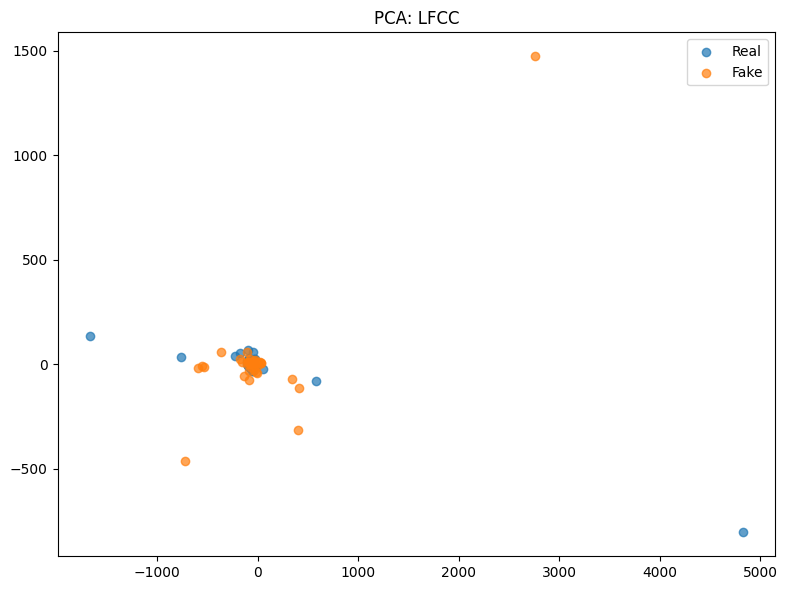

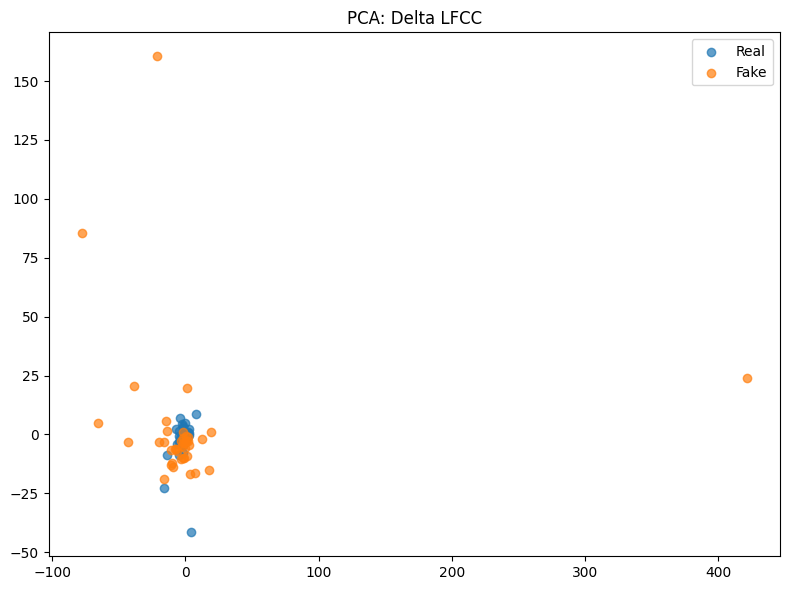

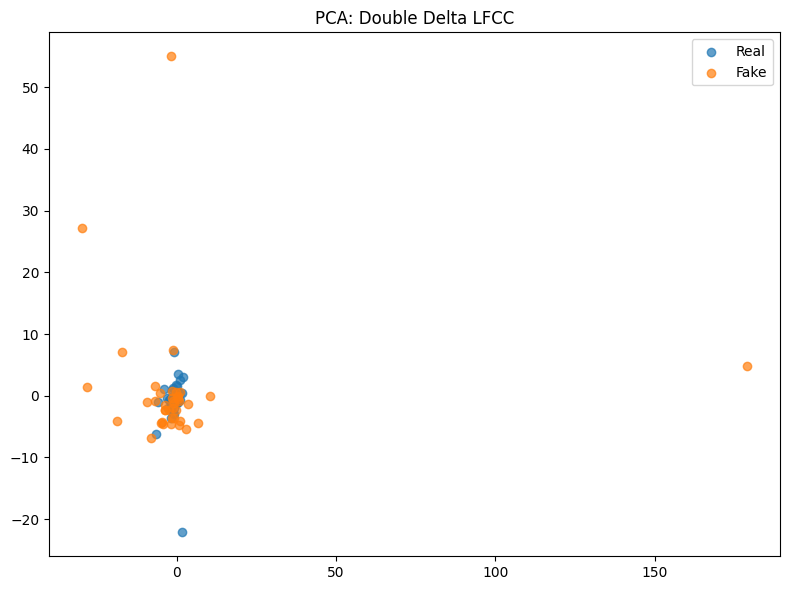

In [ ]:
# 3. PCA 시각화
def plot_pca(real_feature, fake_feature, title):
    real_flat = real_feature.reshape(real_feature.shape[0], -1)
    fake_flat = fake_feature.reshape(fake_feature.shape[0], -1)
    combined = np.vstack((real_flat, fake_flat))

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined)

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:real_flat.shape[0], 0], pca_result[:real_flat.shape[0], 1], label='Real', alpha=0.7)
    plt.scatter(pca_result[real_flat.shape[0]:, 0], pca_result[real_flat.shape[0]:, 1], label='Fake', alpha=0.7)
    plt.title(f'PCA: {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pca(real_lfcc, fake_lfcc, 'LFCC')
plot_pca(real_delta, fake_delta, 'Delta LFCC')
plot_pca(real_double_delta, fake_double_delta, 'Double Delta LFCC')

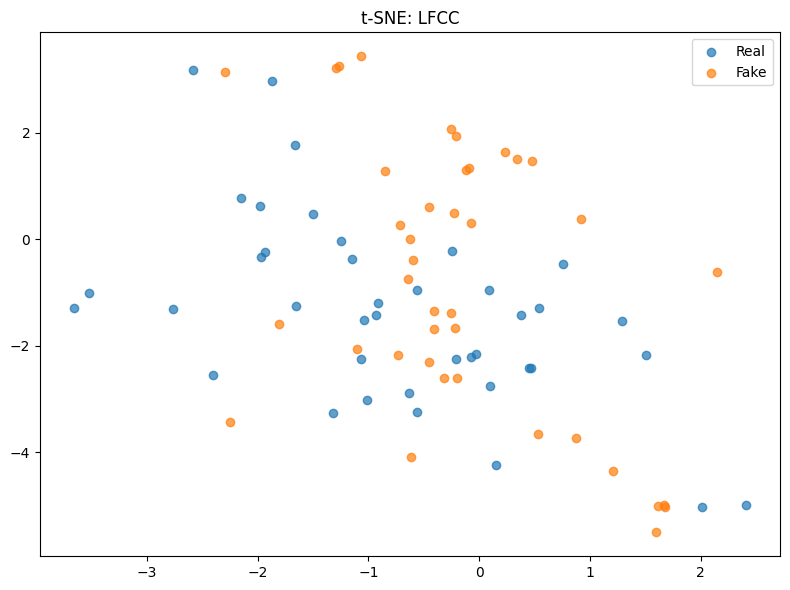

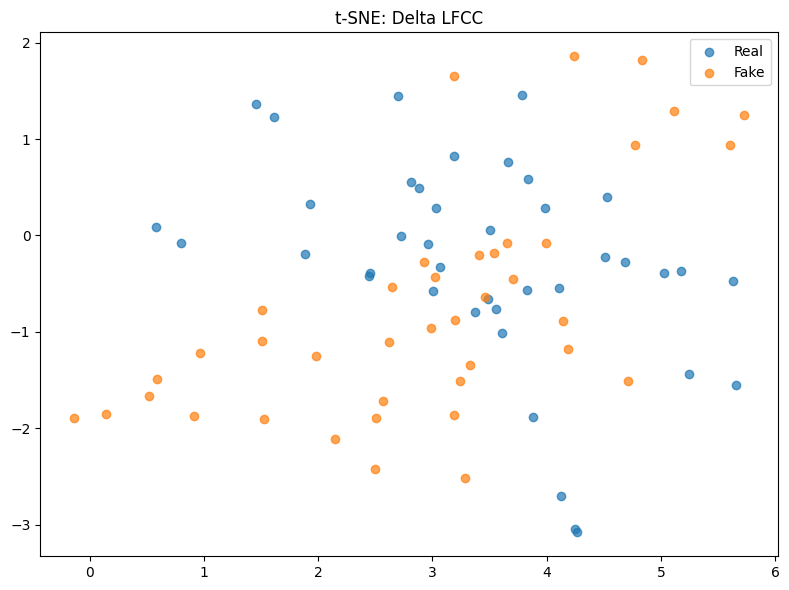

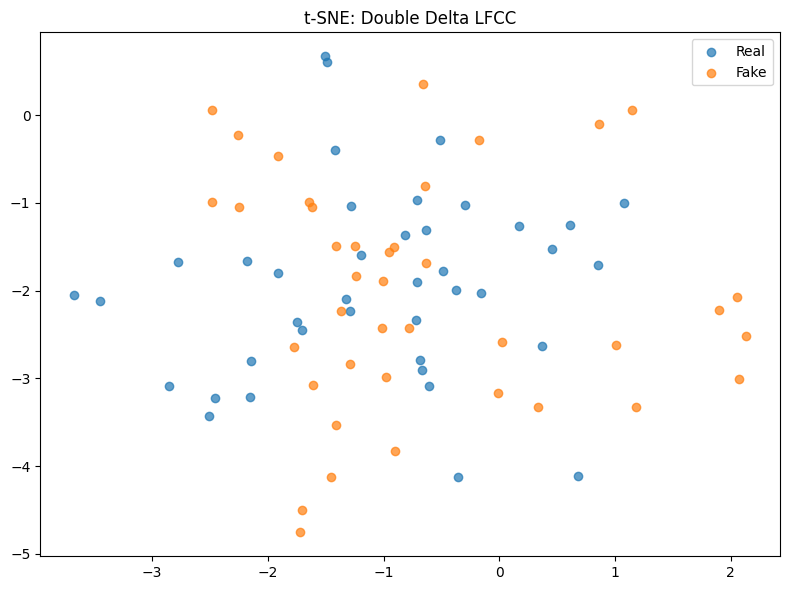

In [ ]:
# 4. t-SNE 시각화
def plot_tsne(real_feature, fake_feature, title):
    real_flat = real_feature.reshape(real_feature.shape[0], -1)
    fake_flat = fake_feature.reshape(fake_feature.shape[0], -1)
    combined = np.vstack((real_flat, fake_flat))

    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(combined)

    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_result[:real_flat.shape[0], 0], tsne_result[:real_flat.shape[0], 1], label='Real', alpha=0.7)
    plt.scatter(tsne_result[real_flat.shape[0]:, 0], tsne_result[real_flat.shape[0]:, 1], label='Fake', alpha=0.7)
    plt.title(f't-SNE: {title}')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_tsne(real_lfcc, fake_lfcc, 'LFCC')
plot_tsne(real_delta, fake_delta, 'Delta LFCC')
plot_tsne(real_double_delta, fake_double_delta, 'Double Delta LFCC')

# 3. SE-ResABNet 모델 구현


---


초기 파라미터 값의 의미:
1. SE 블록의 reduction=16: 채널 수를 16분의 1로 줄여 모델 복잡도와 성능 사이의 균형을 맞춤.
2. ResidualBlock의 kernel_size=3: 3x3 컨볼루션이 효과적인 특징 추출과 계산 효율성 사이의 좋은 균형을 제공.
3. AttentionBranch의 512 채널: 풍부한 특징 표현을 위해 충분히 큰 채널 수를 사용.
4. SE-ResABNet의 레이어 구성 (64 -> 128 -> 256 -> 512): 점진적으로 채널 수를 증가시켜 더 복잡한 특징을 학습할 수 있게 함.
5. num_classes=2: 실제 음성과 가짜 음성을 구분하는 이진 분류 작업을 위한 설정.



---



이 모델 구조는 음성 탐지 작업에 특화되어 있으며,LFCC 특징의 효과적인 추출과 SE-ResABNet의 강력한 분류 능력을 결합하여 실제 음성과 가짜 음성을 높은 정확도로 구분할 수 있도록 설계되었다.

## 1. SE (Squeeze-and-Excitation) 블록 구현

- SE 블록은 채널 간의 상호 의존성을 모델링하여 중요한 특징을 강조한다.
- reduction 파라미터는 중간 레이어의 뉴런 수를 줄여 모델의 복잡도를 조절한다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# SE (Squeeze-and-Excitation) 블록 정의
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        """
        SE 블록 초기화
        :param channel: 입력 채널 수
        :param reduction: 채널 감소 비율 (default: 16)
        """
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # 전역 평균 풀링
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)  # 전역 정보 추출
        y = self.fc(y).view(b, c, 1, 1)  # 채널 별 가중치 계산
        return x * y.expand_as(x)  # 원본 특징에 가중치 적용

## 2. 잔차블록 정의
- 잔차 블록은 깊은 네트워크에서 그래디언트 소실 문제를 해결하고 학습을 안정화한다.
- SE 블록을 포함하여 특징 재보정 효과를 얻는다.

In [ ]:
# 잔차 블록 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        잔차 블록 초기화
        :param in_channels: 입력 채널 수
        :param out_channels: 출력 채널 수
        :param stride: 합성곱 연산의 스트라이드 (default: 1)
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)  # SE 블록 적용
        out += self.shortcut(x)  # 잔차 연결
        out = F.relu(out)
        return out

## 3. 주의분기 정의

- 설명: 주의 분기는 입력 특징의 중요한 부분에 집중할 수 있도록 주의 맵을 생성한다.
-  이는 모델이 관련 정보에 더 집중하도록 돕는다.

In [ ]:
# 주의 분기 정의
class AttentionBranch(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        주의 분기 초기화
        :param in_channels: 입력 채널 수
        :param out_channels: 출력 채널 수
        """
        super(AttentionBranch, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        attention_map = self.sigmoid(out)
        return attention_map


## 4. SE-ResABNet 정의
- SE-ResABNet은 SE 블록, 잔차 연결, 그리고 주의 메커니즘을 결합한 분류기이다. 이 구조는 음성 탐지 작업에 특화되어 있다.



In [ ]:
# SE-ResABNet 정의
class SE_ResABNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SE_ResABNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.attention_branch = AttentionBranch(512, 512)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 적응형 평균 풀링 사용
        self.fc = nn.Linear(512, 512)
        self.classifier = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        """
        잔차 블록들로 구성된 레이어 생성
        """
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        attention_map = self.attention_branch(out)
        out = out * attention_map  # 주의 맵 적용
        out = self.avgpool(out)
        embeddings = out.view(out.size(0), -1)
        embeddings = self.fc(embeddings)
        output = self.classifier(embeddings)
        return output, attention_map, embeddings

## 5. 전체 모델 정의 (LFCC 특징 추출기 + SE-ResABNet)
- 원시 오디오 파형을 입력으로 받아 LFCC 특징을 추출한 후,SE-ResABNet을 통해 분류를 수행한다.
- 출력으로는 클래스 예측, 주의 맵, 그리고 임베딩을 제공한다.


In [ ]:
# 전체 모델 정의 (LFCC 특징 추출기 + SE-ResABNet)
class LFCC_SE_ResABNet(nn.Module):
    def __init__(self, num_classes=2):
        """
        LFCC 특징 추출기와 SE-ResABNet을 결합한 전체 모델 초기화
        :param num_classes: 분류할 클래스 수 (default: 2, 실제/가짜)
        """
        super(LFCC_SE_ResABNet, self).__init__()
        self.lfcc_extractor = LFCCExtractor()  # 이전에 정의한 LFCC 추출기
        self.se_resabnet = SE_ResABNet(num_classes)

    def forward(self, waveform):
        # waveform shape: (batch_size, audio_length)
        lfcc = self.lfcc_extractor(waveform) # Shape: (batch_size, 1, num_lfcc, time)
        output, attention_map, embeddings = self.se_resabnet(lfcc)
        return output, attention_map, embeddings

## 6. 모델 구조 시각화

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

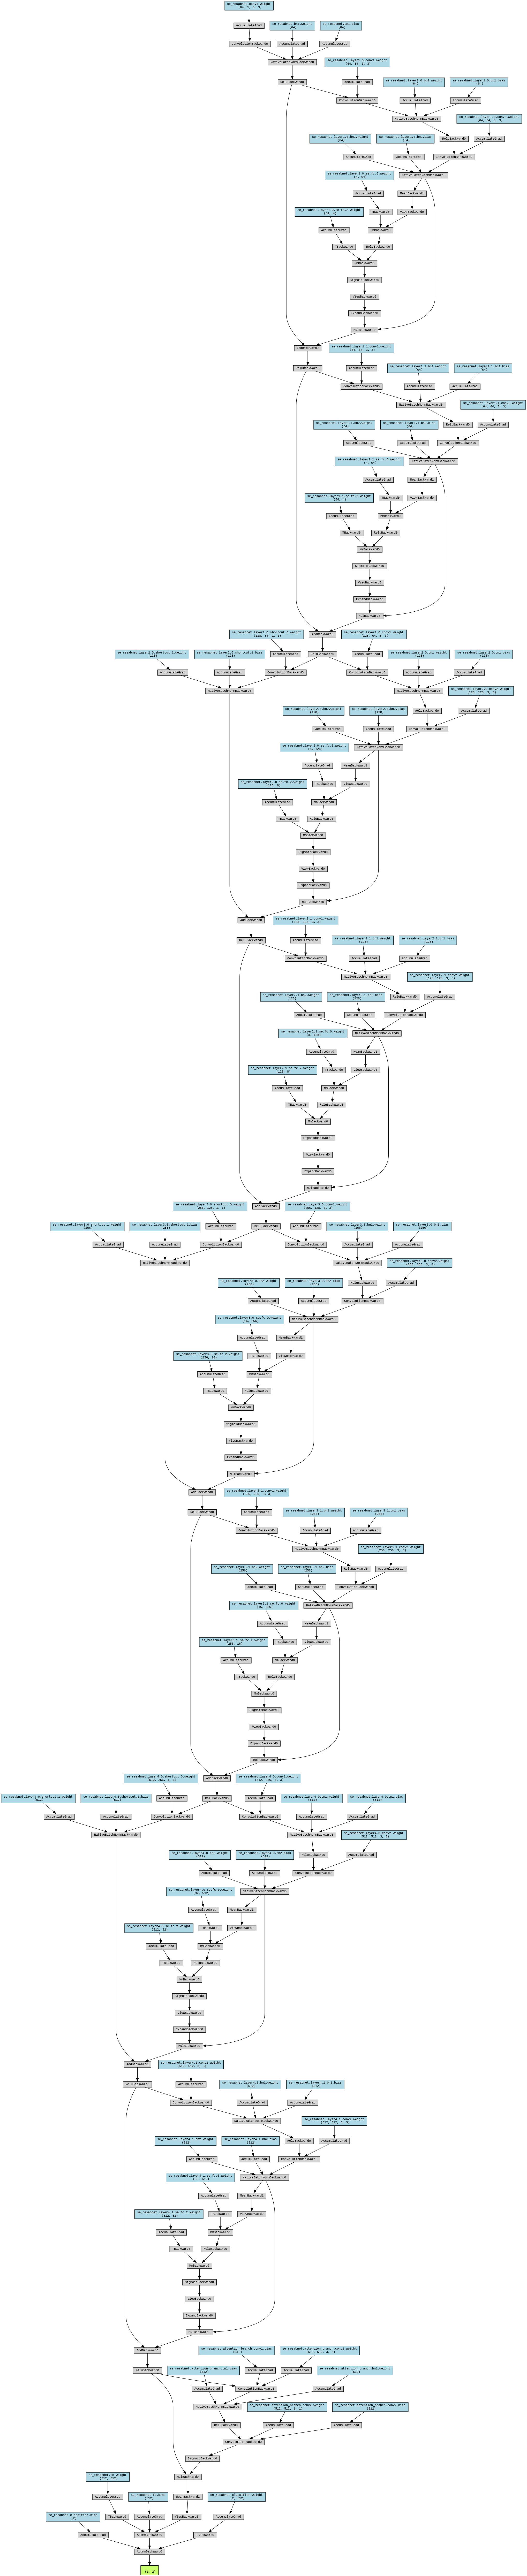

LFCC_SE_ResABNet(
  (lfcc_extractor): LFCCExtractor(
    (lfcc): LFCC(
      (amplitude_to_DB): AmplitudeToDB()
      (Spectrogram): Spectrogram()
    )
  )
  (se_resabnet): SE_ResABNet(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (se): SEBlock(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=64, out_features=4, bias=False)
            (1): ReLU(inpl

In [ ]:
import torchviz
from torchviz import make_dot
import torch
from IPython.display import Image, display
def visualize_model(model, input_size=(1, 16000)):
    # 가변 길이 입력 생성
    x = torch.randn(input_size)

    # 모델 출력 계산
    y, _, _ = model(x)

    # 계산 그래프 생성
    dot = make_dot(y, params=dict(list(model.named_parameters())))

    # 그래프 저장 및 표시
    dot.render("LFCC_SE_ResABNet_model", format="png")
    display(Image("LFCC_SE_ResABNet_model.png"))

# 모델 인스턴스 생성
model = LFCC_SE_ResABNet()

# 모델 구조 시각화 (다양한 입력 길이로 테스트)
visualize_model(model, input_size=(1, 16000))  # 1초 길이
print(model)

# 4. 손실함수 구현

## 1. CombLoss 클래스 구현


---


1. Triplet Center Loss

각 샘플과 해당 클래스 중심 간의 거리를 계산.
다른 클래스 중심과의 최소 거리를 계산.
마진 기반의 triplet loss를 계산.

2. Focal Loss

Cross Entropy Loss 기반
잘못 분류된 샘플에 더 큰 가중치를 부여.


3. Combined Loss

Cross Entropy Loss, Triplet Center Loss, Focal Loss를 결합.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombLoss(nn.Module):
    def __init__(self, num_classes=2, lambda_tcl=0.1, lambda_focal=0.005, alpha=0.25, gamma=2):
        super(CombLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.lambda_tcl = lambda_tcl
        self.lambda_focal = lambda_focal
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma

        # 클래스 중심 초기화
        self.centers = nn.Parameter(torch.randn(num_classes, 512))

    def forward(self, outputs, targets, embeddings):
        ce_loss = self.ce_loss(outputs, targets)
        tcl_loss = self.triplet_center_loss(embeddings, targets)
        focal_loss = self.focal_loss(outputs, targets)
        return ce_loss + self.lambda_tcl * tcl_loss + self.lambda_focal * focal_loss

    def triplet_center_loss(self, embeddings, targets):
        batch_size = embeddings.size(0)
        centers_batch = self.centers.index_select(0, targets)

        # 중심과의 거리 계산
        dist = torch.sum((embeddings - centers_batch) ** 2, dim=1)

        # 다른 클래스 중심과의 거리 계산
        dist_other = torch.sum((embeddings.unsqueeze(1) - self.centers.unsqueeze(0)) ** 2, dim=2)
        mask = torch.ones(batch_size, self.num_classes, device=embeddings.device).scatter_(1, targets.unsqueeze(1), 0)
        dist_other = dist_other * mask

        # 가장 가까운 다른 클래스 중심 찾기
        dist_other = torch.min(dist_other + (1 - mask) * 1e6, dim=1)[0]

        # 마진 기반 triplet loss 계산
        margin = 1.0
        loss = F.relu(dist - dist_other + margin)
        return loss.mean()

    def focal_loss(self, outputs, targets):
        ce_loss = F.cross_entropy(outputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

## 2. 각 손실함수 컴포넌트테스트

In [ ]:
def test_comb_loss():
    loss_fn = CombLoss()
    batch_size = 32
    num_classes = 2
    feature_dim = 512

    # 더미 데이터 생성
    outputs = torch.randn(batch_size, num_classes)
    targets = torch.randint(0, num_classes, (batch_size,))
    embeddings = torch.randn(batch_size, feature_dim)

    # 손실 계산
    loss = loss_fn(outputs, targets, embeddings)
    print(f"Combined Loss: {loss.item()}")

    # 개별 손실 컴포넌트 테스트
    ce_loss = loss_fn.ce_loss(outputs, targets)
    print(f"Cross Entropy Loss: {ce_loss.item()}")

    tcl_loss = loss_fn.triplet_center_loss(embeddings, targets)
    print(f"Triplet Center Loss: {tcl_loss.item()}")

    focal_loss = loss_fn.focal_loss(outputs, targets)
    print(f"Focal Loss: {focal_loss.item()}")

    # 그래디언트 계산 테스트
    loss.backward()
    print("Gradient calculation successful")

if __name__ == "__main__":
    test_comb_loss()

Combined Loss: 3.086097478866577
Cross Entropy Loss: 0.8796142339706421
Triplet Center Loss: 22.05885124206543
Focal Loss: 0.1196228414773941
Gradient calculation successful


# 중간 테스트

In [ ]:
import torch
import torchaudio
import numpy as np
import os

def load_and_preprocess_audio(file_path, target_length=16000):
    waveform, sample_rate = torchaudio.load(file_path)

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)

    if waveform.shape[1] > target_length:
        waveform = waveform[:, :target_length]
    elif waveform.shape[1] < target_length:
        waveform = torch.nn.functional.pad(waveform, (0, target_length - waveform.shape[1]))

    return waveform

def test_with_sample_set():
    # 모델 및 손실 함수 초기화
    model = LFCC_SE_ResABNet()
    loss_fn = CombLoss()

    # 샘플 세트 경로
    base_path = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset'
    real_samples = [
        'RUNQPNJF.ogg', 'RDKEKEVX.ogg', 'QYHJDOFK.ogg', 'RSPQNHAO.ogg', 'ZYAZQJEQ.ogg'
    ]
    fake_samples = [
        'JFAWUOGJ.ogg', 'RFJBXXBT.ogg', 'CHRSGOHZ.ogg', 'IJRWQGKZ.ogg', 'DBNXGCVE.ogg'
    ]

    all_waveforms = []
    all_targets = []

    # 실제 음성 샘플 로드
    for sample in real_samples:
        file_path = os.path.join(base_path, 'train', sample)
        waveform = load_and_preprocess_audio(file_path)
        all_waveforms.append(waveform)
        all_targets.append(0)  # 0: real

    # 가짜 음성 샘플 로드
    for sample in fake_samples:
        file_path = os.path.join(base_path, 'train', sample)
        waveform = load_and_preprocess_audio(file_path)
        all_waveforms.append(waveform)
        all_targets.append(1)  # 1: fake

    # 배치 생성
    batch = torch.cat(all_waveforms, dim=0)
    targets = torch.tensor(all_targets)

    # 모델 추론
    outputs, _, embeddings = model(batch)

    # 손실 계산
    loss = loss_fn(outputs, targets, embeddings)

    print(f"Combined Loss: {loss.item()}")
    print(f"Cross Entropy Loss: {loss_fn.ce_loss(outputs, targets).item()}")
    print(f"Triplet Center Loss: {loss_fn.triplet_center_loss(embeddings, targets).item()}")
    print(f"Focal Loss: {loss_fn.focal_loss(outputs, targets).item()}")

    # 그래디언트 계산 테스트
    loss.backward()
    print("Gradient calculation successful")

    # 예측 결과 출력
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    print(f"Accuracy: {correct / len(targets) * 100:.2f}%")

    # 각 샘플에 대한 예측 결과 출력
    print("\nPrediction results:")
    for i, (sample, target, pred) in enumerate(zip(real_samples + fake_samples, targets, predicted)):
        print(f"{sample}: True label - {'Real' if target == 0 else 'Fake'}, "
              f"Predicted - {'Real' if pred == 0 else 'Fake'}")

if __name__ == "__main__":
    test_with_sample_set()

NameError: name 'LFCC_SE_ResABNet' is not defined

# 5. 데이터셋및 데이터 로더 구현



## 1. AudioDataset 클래스 정의



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pandas as pd
import numpy as np
import os
import random
class AudioDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_length=64000):
        """
        Args:
        csv_file (string): 오디오 파일 경로와 레이블이 있는 CSV 파일 경로.
        root_dir (string): 모든 오디오 파일이 있는 디렉토리.
        transform (callable, optional): 샘플에 적용할 선택적 변환.
        """
        self.audio_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_length = target_length

    def __len__(self):
        return len(self.audio_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_path = os.path.join(self.root_dir, self.audio_frame.iloc[idx, 1])
        audio, sample_rate = torchaudio.load(audio_path)

        # 모노로 변환
        if audio.shape[0] > 1:
            audio = torch.mean(audio, dim=0, keepdim=True)

        # 목표 길이에 맞게 조정
        if audio.shape[1] > self.target_length:
            audio = audio[:, :self.target_length]
        elif audio.shape[1] < self.target_length:
            padding = torch.zeros(1, self.target_length - audio.shape[1])
            audio = torch.cat((audio, padding), dim=1)

        label = self.audio_frame.iloc[idx, 2]
        label = 0 if label == 'real' else 1  # 'real'을 0으로, 'fake'를 1로 변환

        if self.transform:
            audio = self.transform(audio)

        audio = audio.squeeze(0)  # 1차원 텐서로 변환

        return audio, label

## 2. 오디오 증강 클래스 정의

1. pitch_shift: 음성의 피치를 변경

2. speed_change: 음성의 속도를 변경

3. add_background_noise: 배경 소음을 추가

4. simulate_room_reverb: 방 울림을 시뮬레이션

5. add_second_voice: 두 번째 음성을 추가

6. clip_audio: 오디오를 일정 길이로 자르거나 패딩

In [ ]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torchaudio
from IPython.display import Audio, display
from scipy import signal

class AudioTransform:
    def __init__(self, sample_rate=16000):
        self.sample_rate = sample_rate
        self.transforms = [
            self.add_white_noise,
            self.add_colored_noise,
            self.add_sine_noise,
            self.add_impulse_noise,
            self.add_room_reverb
        ]

    def add_white_noise(self, audio, noise_level=(0.1, 0.5)):
        noise_level = random.uniform(*noise_level)
        noise = torch.randn_like(audio) * noise_level
        return audio + noise

    def add_colored_noise(self, audio, noise_color='pink', noise_level=(0.1, 0.5)):
        noise_level = random.uniform(*noise_level)
        noise = torch.randn_like(audio)

        if noise_color == 'pink':
            spectrum = torch.fft.rfft(noise, dim=-1)
            freqs = torch.fft.rfftfreq(noise.shape[-1])
            spectrum *= 1 / torch.where(freqs == 0, 1.0, freqs).sqrt().unsqueeze(0)
            noise = torch.fft.irfft(spectrum, n=noise.shape[-1], dim=-1)
        elif noise_color == 'brown':
            spectrum = torch.fft.rfft(noise, dim=-1)
            freqs = torch.fft.rfftfreq(noise.shape[-1])
            spectrum *= 1 / torch.where(freqs == 0, 1.0, freqs).unsqueeze(0)
            noise = torch.fft.irfft(spectrum, n=noise.shape[-1], dim=-1)
        elif noise_color == 'blue':
            spectrum = torch.fft.rfft(noise, dim=-1)
            freqs = torch.fft.rfftfreq(noise.shape[-1])
            spectrum *= torch.where(freqs == 0, 1.0, freqs).sqrt().unsqueeze(0)
            noise = torch.fft.irfft(spectrum, n=noise.shape[-1], dim=-1)

        noise = noise / noise.std() * noise_level
        return audio + noise

    def add_sine_noise(self, audio, freq_range=(50, 2000), noise_level=(0.1, 0.5)):
        noise_level = random.uniform(*noise_level)
        freq = random.uniform(*freq_range)
        t = torch.arange(0, audio.shape[-1], dtype=torch.float32) / self.sample_rate
        sine_wave = torch.sin(2 * np.pi * freq * t).unsqueeze(0)
        return audio + sine_wave * noise_level

    def add_impulse_noise(self, audio, noise_level=(0.05, 0.2), num_impulses=(1000, 3000)):
        noise_level = random.uniform(*noise_level)
        num_imp = random.randint(*num_impulses)
        noise = torch.zeros_like(audio)
        impulse_positions = torch.randint(0, audio.shape[-1], (num_imp,))
        noise[0, impulse_positions] = torch.randn(num_imp) * noise_level
        return audio + noise

    def add_room_reverb(self, audio, room_scale=(0.6, 0.95), reverberance=(0.3, 0.9)):
        room_scale = random.uniform(*room_scale)
        reverberance = random.uniform(*reverberance)

        audio_np = audio.numpy().squeeze()

        # 임펄스 응답 생성
        impulse_response = np.exp(-np.linspace(0, 1, int(room_scale * len(audio_np))))
        impulse_response = impulse_response * reverberance

        # 컨볼루션 적용
        reverb_audio = signal.convolve(audio_np, impulse_response, mode='same')

        # 정규화
        reverb_audio = reverb_audio / np.max(np.abs(reverb_audio))

        # 원본 오디오와 리버브 오디오 혼합
        mixed_audio = 0.7 * audio_np + 0.3 * reverb_audio

        return torch.from_numpy(mixed_audio).unsqueeze(0).float()


    def __call__(self, audio):
        num_transforms = random.randint(1, 2)
        for _ in range(num_transforms):
            transform = random.choice(self.transforms)
            audio = transform(audio)
        return audio

    def apply_specific_transform(self, audio, transform_index):
        if 0 <= transform_index < len(self.transforms):
            try:
                return self.transforms[transform_index](audio)
            except Exception as e:
                print(f"Error applying transform {transform_index}: {e}")
                return audio
        else:
            return audio



### 증강 적용 예

Fake audio shape: torch.Size([1, 47872]), Sample rate: 32000
Real audio shape: torch.Size([1, 180224]), Sample rate: 32000

Fake Audio:


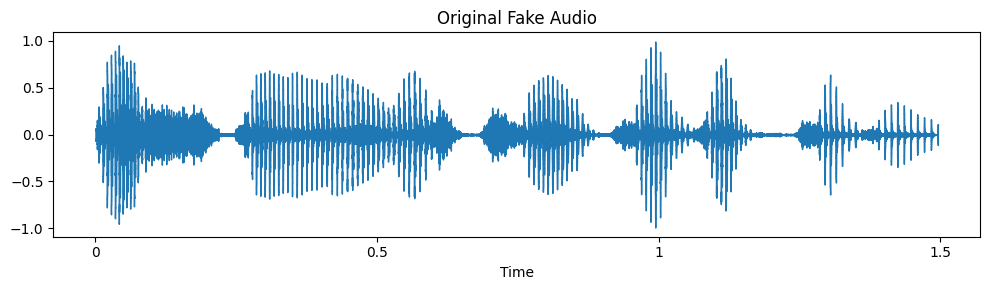

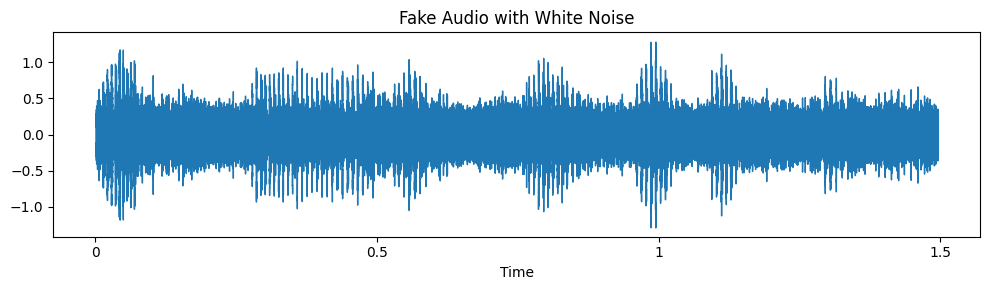

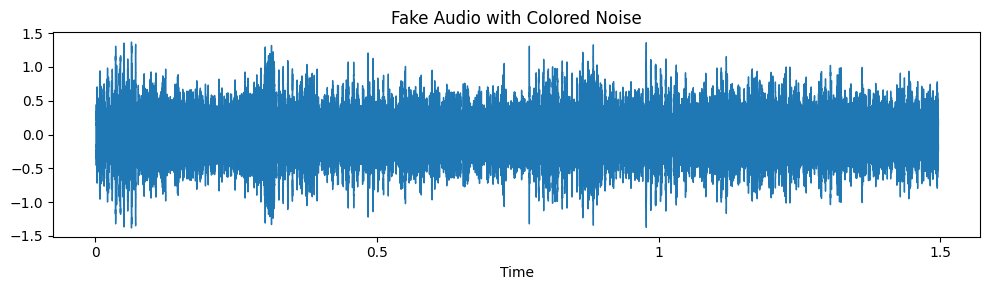

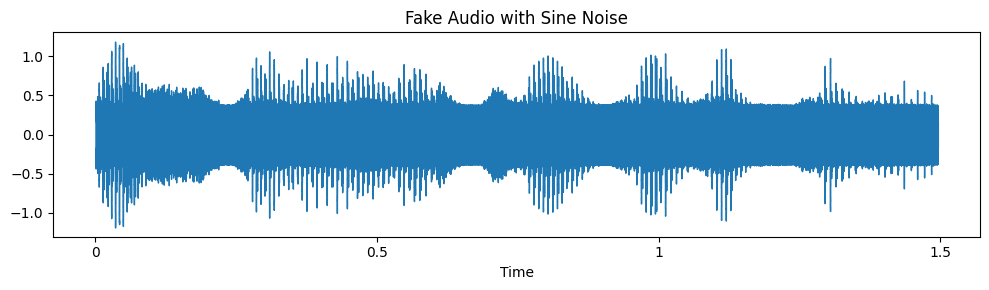

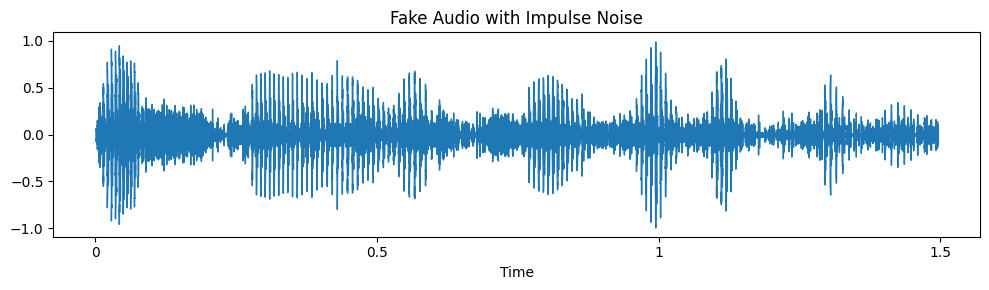

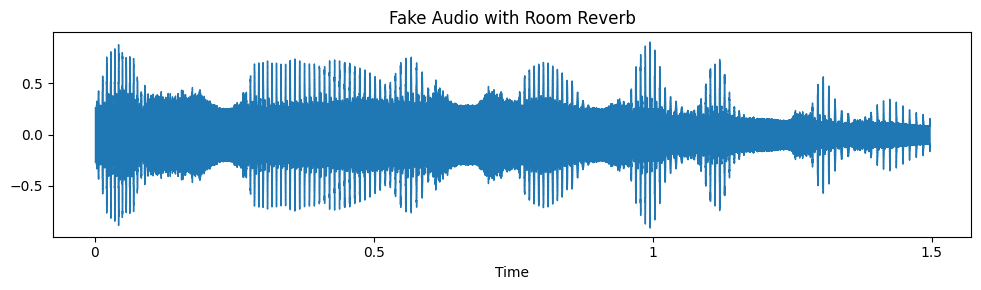

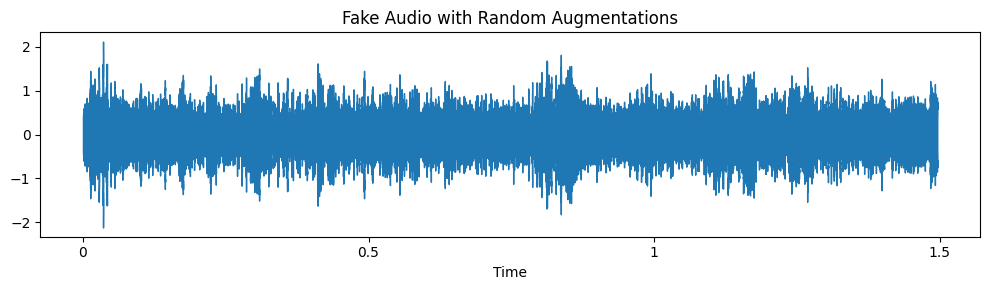


Real Audio:


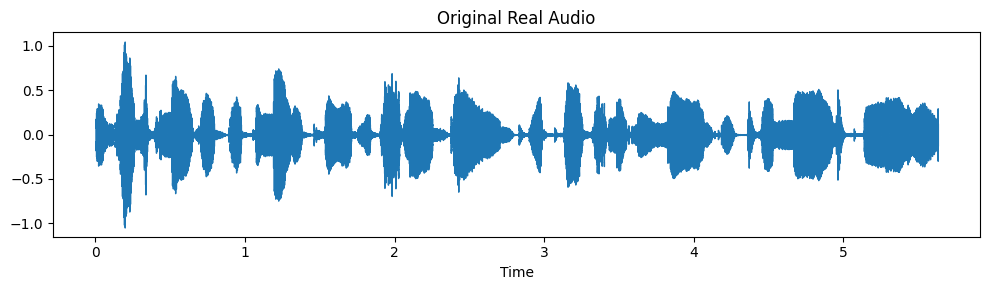

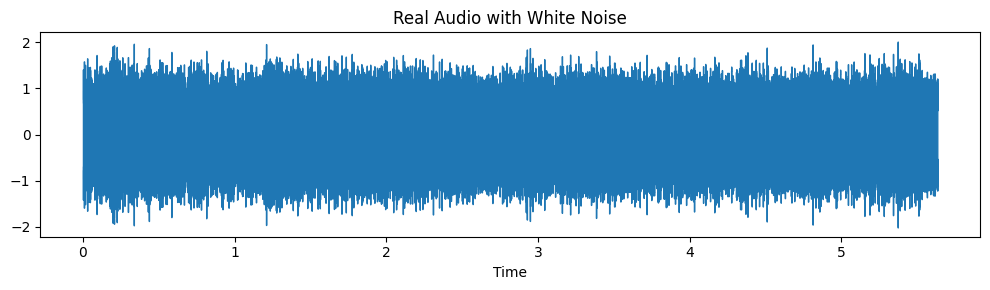

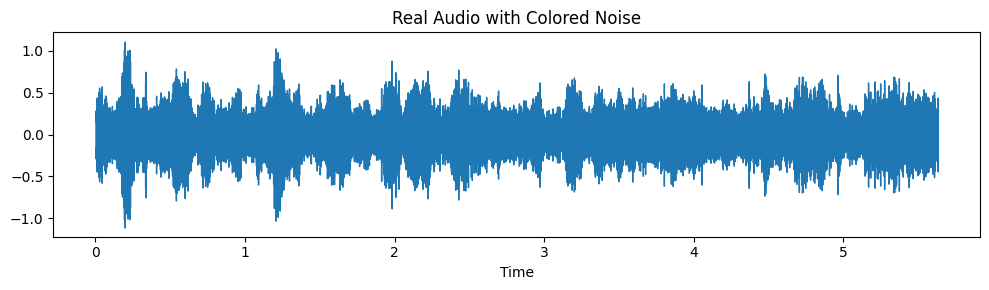

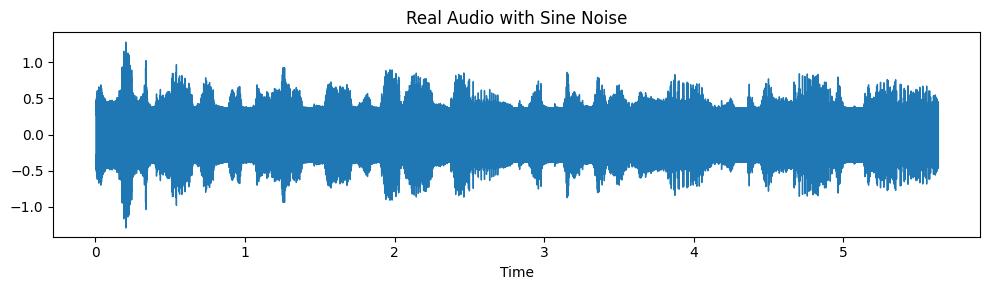

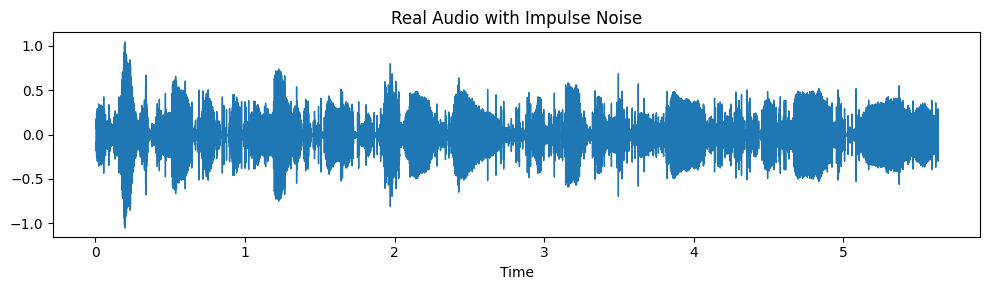

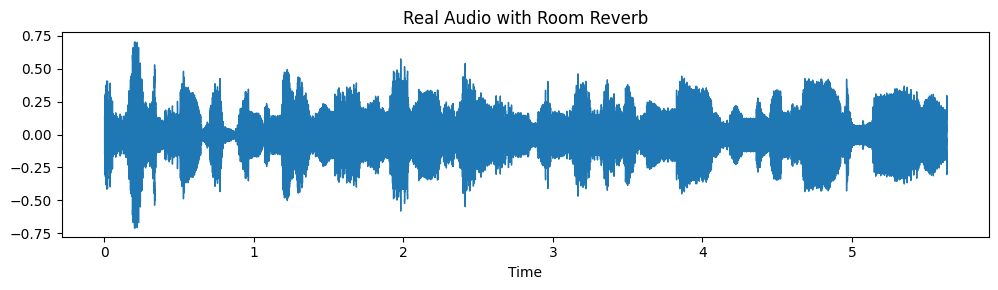

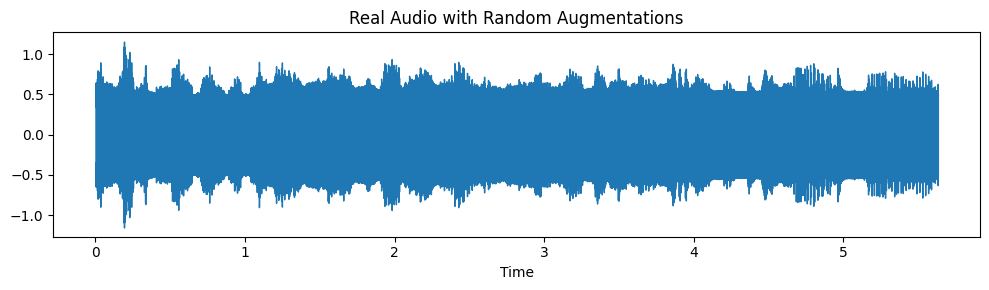

In [ ]:
def plot_waveform(audio, sr, title):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(audio.numpy().squeeze(), sr=sr)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def play_audio(audio, sr):
    return Audio(audio.numpy().squeeze(), rate=sr)

# 가짜 음성과 진짜 음성 로드
real_audio, sr = torchaudio.load("/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train/VONQSLDE.ogg")
fake_audio, sr = torchaudio.load("/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train/CJBSPRHA.ogg")

print(f"Fake audio shape: {fake_audio.shape}, Sample rate: {sr}")
print(f"Real audio shape: {real_audio.shape}, Sample rate: {sr}")

if fake_audio.shape[1] == 0 or real_audio.shape[1] == 0:
    raise ValueError("One or both of the audio files are empty.")

transform = AudioTransform(sample_rate=sr)

# 각 증강 기법 적용 및 결과 출력
for i, audio in enumerate([fake_audio, real_audio]):
    audio_type = "Fake" if i == 0 else "Real"

    print(f"\n{audio_type} Audio:")

    # 원본 오디오
    plot_waveform(audio, sr, f"Original {audio_type} Audio")
    display(play_audio(audio, sr))

    # 각 증강 기법 적용
    for j, transform_name in enumerate(["White Noise", "Colored Noise", "Sine Noise", "Impulse Noise", "Room Reverb"]):
        augmented_audio = transform.apply_specific_transform(audio, j)
        plot_waveform(augmented_audio, sr, f"{audio_type} Audio with {transform_name}")
        display(play_audio(augmented_audio, sr))

    # 랜덤 증강 적용
    random_augmented_audio = transform(audio)
    plot_waveform(random_augmented_audio, sr, f"{audio_type} Audio with Random Augmentations")
    display(play_audio(random_augmented_audio, sr))

## 3. 데이터 로더

In [ ]:
# 데이터셋 및 데이터 로더 생성
def create_dataloaders(csv_file, root_dir, batch_size=32, num_workers=2):
    dataset = AudioDataset(csv_file=csv_file,
                           root_dir=root_dir,
                           transform=AudioTransform())

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


## 4. 테스트

In [ ]:
if __name__ == "__main__":
    csv_file = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train.csv'
    root_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset'

    train_loader, val_loader = create_dataloaders(csv_file, root_dir)

    # 데이터 확인
    for i, (audio, label) in enumerate(train_loader):
        print(f"Batch {i}:")
        print(f"Audio shape: {audio.shape}")
        print(f"Label shape: {label.shape}")
        print(f"Labels: {label}")
        if i == 0:  # 첫 번째 배치만 출력
            break

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3d3d492cb0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3d3d492cb0>

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
AssertionError: can only test a child process    if w.is_alive():

  File "/usr/lib/

Batch 0:
Audio shape: torch.Size([32, 1, 64000])
Label shape: torch.Size([32])
Labels: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0])


# 6. 학습및 평가함수 구현

1. train_epoch: 한 에폭 동안 모델을 학습시키는 함수.
2. evaluate: 모델의 성능을 평가하는 함수.
3. expected_calibration_error: ECE를 계산하는 함수.
4. auc_brier_ece: AUC, Brier Score, ECE를 계산하고 결합된 점수를 반환하는 함수.
5. train_and_evaluate: 전체 학습 및 평가 과정을 관리하는 함수.

## 디바이스 설정

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error, roc_auc_score
import pandas as pd

# TPU 사용을 위한 import (나중에 사용)
# import torch_xla
# import torch_xla.core.xla_model as xm

# 디바이스 설정 (CPU/GPU/TPU)
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    # elif xm.xla_device_hw() == 'TPU':
    #     return xm.xla_device()
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")


Using device: cuda


## 1. train_epoch 함수 정의

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    한 에폭 동안 모델을 학습시키는 함수

    Args:
    model (nn.Module): 학습할 모델
    dataloader (DataLoader): 학습 데이터 로더
    criterion (nn.Module): 손실 함수
    optimizer (optim.Optimizer): 옵티마이저
    device (torch.device): 학습에 사용할 디바이스

    Returns:
    float: 에폭의 평균 손실
    """
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (audio, targets) in enumerate(tqdm(dataloader, desc="Training")):
        audio, targets = audio.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs, _, embeddings = model(audio)
        loss = criterion(outputs, targets, embeddings)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(targets.view_as(pred)).sum().item()
        total += targets.size(0)

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")

    return total_loss / len(dataloader), 100. * correct / total

## 2. 평가 함수 정의

In [ ]:
def evaluate(model, dataloader, criterion, device):
    """
    모델을 평가하는 함수

    Args:
    model (nn.Module): 평가할 모델
    dataloader (DataLoader): 평가 데이터 로더
    criterion (nn.Module): 손실 함수
    device (torch.device): 평가에 사용할 디바이스

    Returns:
    tuple: (평균 손실, 정확도, 예측 확률, 실제 레이블)
    """
    model.eval()
    total_loss = 0.0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for audio, targets in tqdm(dataloader, desc="Evaluating"):
            audio, targets = audio.to(device), targets.to(device)

            outputs, _, embeddings = model(audio)
            loss = criterion(outputs, targets, embeddings)

            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(targets.cpu().numpy())

    accuracy = (np.array(all_probs) > 0.5).astype(int) == np.array(all_labels)
    accuracy = accuracy.mean()

    return total_loss / len(dataloader), accuracy, np.array(all_probs), np.array(all_labels)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    """
    Expected Calibration Error (ECE) 계산

    Args:
    y_true (np.array): 실제 레이블
    y_prob (np.array): 예측 확률
    n_bins (int): 빈의 개수

    Returns:
    float: ECE 값
    """
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins + 1), density=False)[0]
    non_empty_bins = bin_totals > 0
    bin_weights = bin_totals / len(y_prob)
    bin_weights = bin_weights[non_empty_bins]
    prob_true = prob_true[:len(bin_weights)]
    prob_pred = prob_pred[:len(bin_weights)]
    ece = np.sum(bin_weights * np.abs(prob_true - prob_pred))
    return ece

def auc_brier_ece(y_true, y_prob):
    """
    AUC, Brier Score, ECE를 계산하고 결합된 점수를 반환

    Args:
    y_true (np.array): 실제 레이블
    y_prob (np.array): 예측 확률

    Returns:
    float: 결합된 점수
    """
    auc = roc_auc_score(y_true, y_prob)
    brier = mean_squared_error(y_true, y_prob)
    ece = expected_calibration_error(y_true, y_prob)

    combined_score = 0.5 * (1 - auc) + 0.25 * brier + 0.25 * ece
    return combined_score, auc, brier, ece



## 3. 학습및 평가

In [ ]:
# 학습 및 평가 루프
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_probs, val_labels = evaluate(model, val_loader, criterion, device)

        combined_score, auc, brier, ece = auc_brier_ece(val_labels, val_probs)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"AUC: {auc:.4f}, Brier: {brier:.4f}, ECE: {ece:.4f}")
        print(f"Combined Score: {combined_score:.4f}")
        print("-" * 50)

        # TPU 사용 시 추가 (나중에 주석 해제)
        # if isinstance(device, torch_xla.core.xla_model.XLADevice):
        #     xm.mark_step()


## 4. 샘플 데이터 테스트

In [ ]:
def create_small_dataset(csv_file, root_dir, sample_size=100):
    full_dataset = AudioDataset(csv_file, root_dir)

    # 전체 데이터셋에서 무작위로 sample_size만큼 선택
    indices = torch.randperm(len(full_dataset))[:sample_size]
    small_dataset = torch.utils.data.Subset(full_dataset, indices)

    return small_dataset

# 메인 실행 부분
if __name__ == "__main__":
    # 데이터 경로 설정
    csv_file = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train.csv'
    root_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset'

    # 작은 데이터셋 생성
    small_dataset = create_small_dataset(csv_file, root_dir, sample_size=100)

    # 데이터 로더 생성
    train_size = int(0.8 * len(small_dataset))
    val_size = len(small_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(small_dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

    # 모델, 손실 함수, 옵티마이저 초기화
    model = LFCC_SE_ResABNet().to(device)
    criterion = CombLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 학습 및 평가 실행
    train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5)

Training:   0%|          | 0/5 [00:00<?, ?it/s]


RuntimeError: Failed to open the input "/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train/JHCXWBSH.ogg" (No such file or directory).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7b2576d47897 in /usr/local/lib/python3.10/dist-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7b2576cf7b25 in /usr/local/lib/python3.10/dist-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42334 (0x7b2576c86334 in /usr/local/lib/python3.10/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<std::pair<std::string const, std::string> > > > const&) + 0x14 (0x7b2576c88d34 in /usr/local/lib/python3.10/dist-packages/torio/lib/libtorio_ffmpeg4.so)
frame #4: <unknown function> + 0x3aa4e (0x7b24af2a2a4e in /usr/local/lib/python3.10/dist-packages/torio/lib/_torio_ffmpeg4.so)
frame #5: <unknown function> + 0x32617 (0x7b24af29a617 in /usr/local/lib/python3.10/dist-packages/torio/lib/_torio_ffmpeg4.so)
frame #6: <unknown function> + 0x15a10e (0x5ab43653410e in /usr/bin/python3)
frame #7: _PyObject_MakeTpCall + 0x25b (0x5ab43652aa7b in /usr/bin/python3)
frame #8: <unknown function> + 0x168c20 (0x5ab436542c20 in /usr/bin/python3)
frame #9: <unknown function> + 0x165087 (0x5ab43653f087 in /usr/bin/python3)
frame #10: <unknown function> + 0x150e2b (0x5ab43652ae2b in /usr/bin/python3)
frame #11: <unknown function> + 0xf6cb (0x7b25a75f46cb in /usr/local/lib/python3.10/dist-packages/torchaudio/lib/_torchaudio.so)
frame #12: _PyObject_MakeTpCall + 0x25b (0x5ab43652aa7b in /usr/bin/python3)
frame #13: _PyEval_EvalFrameDefault + 0x6a79 (0x5ab436523629 in /usr/bin/python3)
frame #14: _PyObject_FastCallDictTstate + 0xc4 (0x5ab436529c14 in /usr/bin/python3)
frame #15: <unknown function> + 0x164a64 (0x5ab43653ea64 in /usr/bin/python3)
frame #16: _PyObject_MakeTpCall + 0x1fc (0x5ab43652aa1c in /usr/bin/python3)
frame #17: _PyEval_EvalFrameDefault + 0x6a79 (0x5ab436523629 in /usr/bin/python3)
frame #18: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #19: _PyEval_EvalFrameDefault + 0x6bd (0x5ab43651d26d in /usr/bin/python3)
frame #20: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #21: _PyEval_EvalFrameDefault + 0x614a (0x5ab436522cfa in /usr/bin/python3)
frame #22: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #23: _PyEval_EvalFrameDefault + 0x614a (0x5ab436522cfa in /usr/bin/python3)
frame #24: <unknown function> + 0x1c2afe (0x5ab43659cafe in /usr/bin/python3)
frame #25: <unknown function> + 0x1c292e (0x5ab43659c92e in /usr/bin/python3)
frame #26: _PyEval_EvalFrameDefault + 0xbfe (0x5ab43651d7ae in /usr/bin/python3)
frame #27: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #28: _PyEval_EvalFrameDefault + 0x6bd (0x5ab43651d26d in /usr/bin/python3)
frame #29: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #30: _PyEval_EvalFrameDefault + 0x8ac (0x5ab43651d45c in /usr/bin/python3)
frame #31: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #32: _PyEval_EvalFrameDefault + 0x8ac (0x5ab43651d45c in /usr/bin/python3)
frame #33: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #34: _PyEval_EvalFrameDefault + 0x8ac (0x5ab43651d45c in /usr/bin/python3)
frame #35: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #36: _PyEval_EvalFrameDefault + 0x8ac (0x5ab43651d45c in /usr/bin/python3)
frame #37: <unknown function> + 0x1c2afe (0x5ab43659cafe in /usr/bin/python3)
frame #38: <unknown function> + 0x28c7b3 (0x5ab4366667b3 in /usr/bin/python3)
frame #39: _PyEval_EvalFrameDefault + 0xaa0 (0x5ab43651d650 in /usr/bin/python3)
frame #40: <unknown function> + 0x177cc2 (0x5ab436551cc2 in /usr/bin/python3)
frame #41: <unknown function> + 0x1d0e87 (0x5ab4365aae87 in /usr/bin/python3)
frame #42: _PyEval_EvalFrameDefault + 0xaa0 (0x5ab43651d650 in /usr/bin/python3)
frame #43: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #44: _PyEval_EvalFrameDefault + 0x6bd (0x5ab43651d26d in /usr/bin/python3)
frame #45: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #46: _PyEval_EvalFrameDefault + 0x198c (0x5ab43651e53c in /usr/bin/python3)
frame #47: <unknown function> + 0x13f9c6 (0x5ab4365199c6 in /usr/bin/python3)
frame #48: PyEval_EvalCode + 0x86 (0x5ab43660f256 in /usr/bin/python3)
frame #49: <unknown function> + 0x23ae2d (0x5ab436614e2d in /usr/bin/python3)
frame #50: <unknown function> + 0x15ac59 (0x5ab436534c59 in /usr/bin/python3)
frame #51: _PyEval_EvalFrameDefault + 0x6bd (0x5ab43651d26d in /usr/bin/python3)
frame #52: <unknown function> + 0x177ff0 (0x5ab436551ff0 in /usr/bin/python3)
frame #53: _PyEval_EvalFrameDefault + 0x2568 (0x5ab43651f118 in /usr/bin/python3)
frame #54: <unknown function> + 0x177ff0 (0x5ab436551ff0 in /usr/bin/python3)
frame #55: _PyEval_EvalFrameDefault + 0x2568 (0x5ab43651f118 in /usr/bin/python3)
frame #56: <unknown function> + 0x177ff0 (0x5ab436551ff0 in /usr/bin/python3)
frame #57: <unknown function> + 0x2557af (0x5ab43662f7af in /usr/bin/python3)
frame #58: <unknown function> + 0x1662ca (0x5ab4365402ca in /usr/bin/python3)
frame #59: _PyEval_EvalFrameDefault + 0x8ac (0x5ab43651d45c in /usr/bin/python3)
frame #60: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #61: _PyEval_EvalFrameDefault + 0x6bd (0x5ab43651d26d in /usr/bin/python3)
frame #62: _PyFunction_Vectorcall + 0x7c (0x5ab4365349fc in /usr/bin/python3)
frame #63: _PyEval_EvalFrameDefault + 0x8ac (0x5ab43651d45c in /usr/bin/python3)


# 7. 학습-CPU

In [ ]:
device = torch.device('cpu')

In [ ]:
import os
import torch

def main():
    # 데이터 경로 설정
    csv_file = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train.csv'
    root_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset'
    save_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/models'


    # 하이퍼파라미터 설정
    batch_size = 8
    num_epochs = 40
    learning_rate = 0.001
    patience = 10  # early stopping을 위한 patience

    # 데이터 로더 생성 (데이터 증강 포함)
    train_loader, val_loader = create_dataloaders(csv_file, root_dir, batch_size=batch_size)

    # 모델, 손실 함수, 옵티마이저 초기화
    model = LFCC_SE_ResABNet().to(device)
    criterion = CombLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    best_combined_score = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    start_epoch = 0

    # 저장 디렉토리 생성
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(start_epoch, num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_probs, val_labels = evaluate(model, val_loader, criterion, device)

        combined_score, auc, brier, ece = auc_brier_ece(val_labels, val_probs)

        # 학습률 스케줄링
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"AUC: {auc:.4f}, Brier: {brier:.4f}, ECE: {ece:.4f}")
        print(f"Combined Score: {combined_score:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)

        if combined_score < best_combined_score:
            best_combined_score = combined_score
            best_epoch = epoch + 1
            epochs_no_improve = 0
            # 최고의 모델 저장
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered")
                break

        # 20% 단위로 체크포인트 저장
        if (epoch + 1) % (num_epochs // 5) == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_combined_score': best_combined_score,
                'best_epoch': best_epoch,
                'epochs_no_improve': epochs_no_improve
            }
            torch.save(checkpoint, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

    # 학습 완료 후 성능 요약
    print("\n===== Training Complete =====")
    print(f"Best Epoch: {best_epoch}")
    print(f"Best Combined Score: {best_combined_score:.4f}")

    # 최고의 모델로 최종 평가
    model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pth')))
    final_loss, final_acc, final_probs, final_labels = evaluate(model, val_loader, criterion, device)
    final_combined_score, final_auc, final_brier, final_ece = auc_brier_ece(final_labels, final_probs)

    print("\nFinal Model Performance:")
    print(f"Validation Accuracy: {final_acc:.4f}")
    print(f"AUC: {final_auc:.4f}")
    print(f"Brier Score: {final_brier:.4f}")
    print(f"ECE: {final_ece:.4f}")
    print(f"Combined Score: {final_combined_score:.4f}")

def resume_training():
    # 데이터 경로 설정
    csv_file = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train.csv'
    root_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset'
    save_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/models'

    # 하이퍼파라미터 설정
    batch_size = 8
    num_epochs = 40
    learning_rate = 0.001
    patience = 10  # early stopping을 위한 patience

    # 데이터 로더 생성 (데이터 증강 포함)
    train_loader, val_loader = create_dataloaders(csv_file, root_dir, batch_size=batch_size)

    # 모델, 손실 함수, 옵티마이저 초기화
    model = LFCC_SE_ResABNet().to(device)
    criterion = CombLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # 가장 최근의 체크포인트 찾기
    checkpoint_files = [f for f in os.listdir(save_dir) if f.startswith('checkpoint_epoch_')]
    if not checkpoint_files:
        print("No checkpoint found. Starting from scratch.")
        return main()

    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(save_dir, latest_checkpoint)

    # 체크포인트 로드
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_combined_score = checkpoint['best_combined_score']
    best_epoch = checkpoint['best_epoch']
    epochs_no_improve = checkpoint['epochs_no_improve']

    print(f"Resuming from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_probs, val_labels = evaluate(model, val_loader, criterion, device)

        combined_score, auc, brier, ece = auc_brier_ece(val_labels, val_probs)

        # 학습률 스케줄링
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"AUC: {auc:.4f}, Brier: {brier:.4f}, ECE: {ece:.4f}")
        print(f"Combined Score: {combined_score:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)

        if combined_score < best_combined_score:
            best_combined_score = combined_score
            best_epoch = epoch + 1
            epochs_no_improve = 0
            # 최고의 모델 저장
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered")
                break

        # 20% 단위로 체크포인트 저장
        if (epoch + 1) % (num_epochs // 5) == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_combined_score': best_combined_score,
                'best_epoch': best_epoch,
                'epochs_no_improve': epochs_no_improve
            }
            torch.save(checkpoint, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

    # 학습 완료 후 성능 요약
    print("\n===== Training Complete =====")
    print(f"Best Epoch: {best_epoch}")
    print(f"Best Combined Score: {best_combined_score:.4f}")

    # 최고의 모델로 최종 평가
    model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pth')))
    final_loss, final_acc, final_probs, final_labels = evaluate(model, val_loader, criterion, device)
    final_combined_score, final_auc, final_brier, final_ece = auc_brier_ece(final_labels, final_probs)

    print("\nFinal Model Performance:")
    print(f"Validation Accuracy: {final_acc:.4f}")
    print(f"AUC: {final_auc:.4f}")
    print(f"Brier Score: {final_brier:.4f}")
    print(f"ECE: {final_ece:.4f}")
    print(f"Combined Score: {final_combined_score:.4f}")



In [ ]:
# 학습 시작 또는 재개
if __name__ == "__main__":
    resume_training()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


No checkpoint found. Starting from scratch.


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


NameError: name 'train_epoch' is not defined

# 7. 학습-GPU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombLoss(nn.Module):
    def __init__(self, num_classes=2, lambda_tcl=0.1, lambda_focal=0.005, alpha=0.25, gamma=2):
        super(CombLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.lambda_tcl = lambda_tcl
        self.lambda_focal = lambda_focal
        self.num_classes = num_classes
        self.alpha = alpha
        self.gamma = gamma

        # 클래스 중심 초기화
        self.centers = nn.Parameter((torch.randn(num_classes, 512)).to(device))
        self.device=device

    def forward(self, outputs, targets, embeddings):
        ce_loss = self.ce_loss(outputs, targets)
        tcl_loss = self.triplet_center_loss(embeddings, targets)
        focal_loss = self.focal_loss(outputs, targets)
        return ce_loss + self.lambda_tcl * tcl_loss + self.lambda_focal * focal_loss

    def triplet_center_loss(self, embeddings, targets):
        batch_size = embeddings.size(0)
        centers_batch = self.centers.index_select(0, targets.to(self.device))

        # 중심과의 거리 계산
        dist = torch.sum((embeddings - centers_batch) ** 2, dim=1)

        # 다른 클래스 중심과의 거리 계산
        dist_other = torch.sum((embeddings.unsqueeze(1) - self.centers.unsqueeze(0)) ** 2, dim=2)
        mask = torch.ones(batch_size, self.num_classes, device=embeddings.device).scatter_(1, targets.unsqueeze(1), 0)
        dist_other = dist_other * mask

        # 가장 가까운 다른 클래스 중심 찾기
        dist_other = torch.min(dist_other + (1 - mask) * 1e6, dim=1)[0]

        # 마진 기반 triplet loss 계산
        margin = 1.0
        loss = F.relu(dist - dist_other + margin)
        return loss.mean()

    def focal_loss(self, outputs, targets):
        ce_loss = F.cross_entropy(outputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [ ]:
# 데이터셋 및 데이터 로더 생성
def create_dataloaders(csv_file, root_dir, batch_size=32, num_workers=4, pin_memory=True):
    dataset = AudioDataset(csv_file=csv_file,
                           root_dir=root_dir,
                           transform=AudioTransform())

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader


In [ ]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from tqdm import tqdm
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def print_gpu_utilization():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.3f} GB")
    print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.3f} GB")

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (audio, targets) in enumerate(tqdm(dataloader, desc="Training")):
        audio, targets = audio.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs, _, embeddings = model(audio)
        loss = criterion(outputs, targets, embeddings)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(targets.view_as(pred)).sum().item()
        total += targets.size(0)

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")

        del audio, targets, outputs, loss
        torch.cuda.empty_cache()

    return total_loss / len(dataloader), 100. * correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for audio, targets in tqdm(dataloader, desc="Evaluating"):
            audio, targets = audio.to(device), targets.to(device)

            outputs, _, embeddings = model(audio)
            loss = criterion(outputs, targets, embeddings)

            total_loss += loss.item()

            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(targets.cpu().numpy())

    accuracy = (np.array(all_probs) > 0.5).astype(int) == np.array(all_labels)
    accuracy = accuracy.mean()

    return total_loss / len(dataloader), accuracy, np.array(all_probs), np.array(all_labels)

def expected_calibration_error(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins + 1), density=False)[0]
    non_empty_bins = bin_totals > 0
    bin_weights = bin_totals / len(y_prob)
    bin_weights = bin_weights[non_empty_bins]
    prob_true = prob_true[:len(bin_weights)]
    prob_pred = prob_pred[:len(bin_weights)]
    ece = np.sum(bin_weights * np.abs(prob_true - prob_pred))
    return ece

def auc_brier_ece(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    brier = mean_squared_error(y_true, y_prob)
    ece = expected_calibration_error(y_true, y_prob)

    combined_score = 0.5 * (1 - auc) + 0.25 * brier + 0.25 * ece
    return combined_score, auc, brier, ece

def main():
    # 데이터 경로 설정
    csv_file = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train.csv'
    root_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset'
    save_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/models'

    # 하이퍼파라미터 설정
    batch_size = 64
    num_epochs = 40
    learning_rate = 0.0002
    patience = 10  # early stopping을 위한 patience

    # 데이터 로더 생성 (데이터 증강 포함)
    num_workers = 4
    pin_memory = True
    train_loader, val_loader = create_dataloaders(csv_file, root_dir, batch_size=batch_size,
                                                  num_workers=num_workers, pin_memory=pin_memory)

    # 모델, 손실 함수, 옵티마이저 초기화
    model = LFCC_SE_ResABNet().to(device)
    criterion = CombLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    best_combined_score = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    start_epoch = 0

    # 저장 디렉토리 생성
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(start_epoch, num_epochs):
        print_gpu_utilization()
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_probs, val_labels = evaluate(model, val_loader, criterion, device)

        combined_score, auc, brier, ece = auc_brier_ece(val_labels, val_probs)

        # 학습률 스케줄링
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"AUC: {auc:.4f}, Brier: {brier:.4f}, ECE: {ece:.4f}")
        print(f"Combined Score: {combined_score:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)

        if combined_score < best_combined_score:
            best_combined_score = combined_score
            best_epoch = epoch + 1
            epochs_no_improve = 0
            # 최고의 모델 저장
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered")
                break

        # 10% 단위로 체크포인트 저장
        if (epoch + 1) % (num_epochs // 10) == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_combined_score': best_combined_score,
                'best_epoch': best_epoch,
                'epochs_no_improve': epochs_no_improve
            }
            torch.save(checkpoint, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

        torch.cuda.empty_cache()

    # 학습 완료 후 성능 요약
    print("\n===== Training Complete =====")
    print(f"Best Epoch: {best_epoch}")
    print(f"Best Combined Score: {best_combined_score:.4f}")

    # 최고의 모델로 최종 평가
    model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pth'), map_location=device))
    final_loss, final_acc, final_probs, final_labels = evaluate(model, val_loader, criterion, device)
    final_combined_score, final_auc, final_brier, final_ece = auc_brier_ece(final_labels, final_probs)

    print("\nFinal Model Performance:")
    print(f"Validation Accuracy: {final_acc:.4f}")
    print(f"AUC: {final_auc:.4f}")
    print(f"Brier Score: {final_brier:.4f}")
    print(f"ECE: {final_ece:.4f}")
    print(f"Combined Score: {final_combined_score:.4f}")

def resume_training():
    # 데이터 경로 설정
    csv_file = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/train.csv'
    root_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset'
    save_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/models'

    # 하이퍼파라미터 설정
    batch_size = 64
    num_epochs = 40
    learning_rate = 0.0002
    patience = 10  # early stopping을 위한 patience

    # 데이터 로더 생성 (데이터 증강 포함)
    num_workers = 4
    pin_memory = True
    train_loader, val_loader = create_dataloaders(csv_file, root_dir, batch_size=batch_size,
                                                  num_workers=num_workers, pin_memory=pin_memory)

    # 모델, 손실 함수, 옵티마이저 초기화
    model = LFCC_SE_ResABNet().to(device)
    criterion = CombLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # 가장 최근의 체크포인트 찾기
    checkpoint_files = [f for f in os.listdir(save_dir) if f.startswith('checkpoint_epoch_')]
    if not checkpoint_files:
        print("No checkpoint found. Starting from scratch.")
        return main()

    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(save_dir, latest_checkpoint)

    # 체크포인트 로드
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    best_combined_score = checkpoint['best_combined_score']
    best_epoch = checkpoint['best_epoch']
    epochs_no_improve = checkpoint['epochs_no_improve']

    print(f"Resuming from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        print_gpu_utilization()
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_probs, val_labels = evaluate(model, val_loader, criterion, device)

        combined_score, auc, brier, ece = auc_brier_ece(val_labels, val_probs)

        # 학습률 스케줄링
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"AUC: {auc:.4f}, Brier: {brier:.4f}, ECE: {ece:.4f}")
        print(f"Combined Score: {combined_score:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)

        if combined_score < best_combined_score:
            best_combined_score = combined_score
            best_epoch = epoch + 1
            epochs_no_improve = 0
            # 최고의 모델 저장
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping triggered")
                break

        # 10% 단위로 체크포인트 저장
        if (epoch + 1) % (num_epochs // 10) == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_combined_score': best_combined_score,
                'best_epoch': best_epoch,
                'epochs_no_improve': epochs_no_improve
            }
            torch.save(checkpoint, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

        torch.cuda.empty_cache()

    # 학습 완료 후 성능 요약
    print("\n===== Training Complete =====")
    print(f"Best Epoch: {best_epoch}")
    print(f"Best Combined Score: {best_combined_score:.4f}")

    # 최고의 모델로 최종 평가
    model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model.pth'), map_location=device))
    final_loss, final_acc, final_probs, final_labels = evaluate(model, val_loader, criterion, device)
    final_combined_score, final_auc, final_brier, final_ece = auc_brier_ece(final_labels, final_probs)

    print("\nFinal Model Performance:")
    print(f"Validation Accuracy: {final_acc:.4f}")
    print(f"AUC: {final_auc:.4f}")
    print(f"Brier Score: {final_brier:.4f}")
    print(f"ECE: {final_ece:.4f}")
    print(f"Combined Score: {final_combined_score:.4f}")



Using device: cuda


In [ ]:
# 학습 시작 또는 재개
if __name__ == "__main__":
    resume_training()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Resuming from epoch 24
GPU memory allocated: 0.691 GB
GPU memory cached: 0.744 GB


Training:   0%|          | 0/693 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 612.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.59 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 612.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass

Batch 0/693, Loss: 1.5795


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 860.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training:   0%|          | 2/693 [00:54<4:22:34, 22.80s/it]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.38 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training:   0%|          | 3/693 [00:58<2:43:07, 14.18s/it]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 860.00 MiB. GPU  (Tri

Batch 10/693, Loss: 0.1829


Training:   3%|▎         | 21/693 [04:23<2:43:21, 14.59s/it]

Batch 20/693, Loss: 0.3146


Training:   4%|▍         | 31/693 [05:59<1:41:23,  9.19s/it]

Batch 30/693, Loss: 0.0825


Training:   6%|▌         | 41/693 [08:02<2:42:12, 14.93s/it]

Batch 40/693, Loss: 0.1592


Training:   7%|▋         | 51/693 [09:35<1:36:45,  9.04s/it]

Batch 50/693, Loss: 0.1767


Training:   9%|▉         | 61/693 [11:42<2:38:03, 15.01s/it]

Batch 60/693, Loss: 0.1552


Training:  10%|█         | 71/693 [13:15<1:32:06,  8.88s/it]

Batch 70/693, Loss: 0.1145


Training:  12%|█▏        | 81/693 [15:19<2:34:30, 15.15s/it]

Batch 80/693, Loss: 0.0878


Training:  13%|█▎        | 91/693 [16:51<1:29:55,  8.96s/it]

Batch 90/693, Loss: 0.1082


Training:  15%|█▍        | 101/693 [18:54<2:31:19, 15.34s/it]

Batch 100/693, Loss: 0.1981


Training:  16%|█▌        | 111/693 [20:27<1:28:38,  9.14s/it]

Batch 110/693, Loss: 0.2802


Training:  17%|█▋        | 121/693 [22:32<2:25:20, 15.25s/it]

Batch 120/693, Loss: 0.1091


Training:  19%|█▉        | 131/693 [24:04<1:24:20,  9.00s/it]

Batch 130/693, Loss: 0.0842


Training:  20%|██        | 141/693 [26:12<2:25:23, 15.80s/it]

Batch 140/693, Loss: 0.0928


Training:  22%|██▏       | 151/693 [27:45<1:24:23,  9.34s/it]

Batch 150/693, Loss: 0.1288


Training:  23%|██▎       | 161/693 [29:48<2:12:17, 14.92s/it]

Batch 160/693, Loss: 0.1671


Training:  25%|██▍       | 171/693 [31:21<1:18:10,  8.99s/it]

Batch 170/693, Loss: 0.1437


Training:  26%|██▌       | 181/693 [33:21<2:03:26, 14.47s/it]

Batch 180/693, Loss: 0.1755


Training:  28%|██▊       | 191/693 [34:53<1:14:07,  8.86s/it]

Batch 190/693, Loss: 0.1429


Training:  29%|██▉       | 201/693 [36:51<1:55:51, 14.13s/it]

Batch 200/693, Loss: 0.2120


Training:  30%|███       | 211/693 [38:26<1:16:05,  9.47s/it]

Batch 210/693, Loss: 0.2617


Training:  32%|███▏      | 221/693 [40:24<1:51:59, 14.24s/it]

Batch 220/693, Loss: 0.0784


Training:  33%|███▎      | 231/693 [42:00<1:11:55,  9.34s/it]

Batch 230/693, Loss: 0.1516


Training:  35%|███▍      | 241/693 [44:00<1:52:53, 14.99s/it]

Batch 240/693, Loss: 0.0615


Training:  36%|███▌      | 251/693 [45:32<1:06:48,  9.07s/it]

Batch 250/693, Loss: 0.1127


Training:  38%|███▊      | 261/693 [47:34<1:47:41, 14.96s/it]

Batch 260/693, Loss: 0.1470


Training:  39%|███▉      | 271/693 [49:11<1:08:35,  9.75s/it]

Batch 270/693, Loss: 0.3068


Training:  41%|████      | 281/693 [51:10<1:40:29, 14.64s/it]

Batch 280/693, Loss: 0.1359


Training:  42%|████▏     | 291/693 [52:43<1:00:01,  8.96s/it]

Batch 290/693, Loss: 0.0696


Training:  43%|████▎     | 301/693 [54:45<1:37:25, 14.91s/it]

Batch 300/693, Loss: 0.1933


Training:  45%|████▍     | 311/693 [56:17<58:17,  9.16s/it]  

Batch 310/693, Loss: 0.2592


Training:  46%|████▋     | 321/693 [58:19<1:34:16, 15.20s/it]

Batch 320/693, Loss: 0.1492


Training:  48%|████▊     | 331/693 [59:52<55:46,  9.25s/it]  

Batch 330/693, Loss: 0.1305


Training:  49%|████▉     | 341/693 [1:01:55<1:28:29, 15.08s/it]

Batch 340/693, Loss: 0.2146


Training:  51%|█████     | 351/693 [1:03:27<51:40,  9.06s/it]  

Batch 350/693, Loss: 0.2433


Training:  52%|█████▏    | 361/693 [1:05:28<1:21:47, 14.78s/it]

Batch 360/693, Loss: 0.0739


Training:  54%|█████▎    | 371/693 [1:07:00<49:29,  9.22s/it]  

Batch 370/693, Loss: 0.1860


Training:  55%|█████▍    | 381/693 [1:09:03<1:17:18, 14.87s/it]

Batch 380/693, Loss: 0.1183


Training:  56%|█████▋    | 391/693 [1:10:37<46:14,  9.19s/it]

Batch 390/693, Loss: 0.1436


Training:  58%|█████▊    | 401/693 [1:12:40<1:12:44, 14.95s/it]

Batch 400/693, Loss: 0.1228


Training:  59%|█████▉    | 411/693 [1:14:11<41:43,  8.88s/it]

Batch 410/693, Loss: 0.1303


Training:  61%|██████    | 421/693 [1:16:12<1:07:25, 14.87s/it]

Batch 420/693, Loss: 0.2938


Training:  62%|██████▏   | 431/693 [1:17:44<40:10,  9.20s/it]

Batch 430/693, Loss: 0.1449


Training:  64%|██████▎   | 441/693 [1:19:44<1:02:38, 14.91s/it]

Batch 440/693, Loss: 0.1788


Training:  65%|██████▌   | 451/693 [1:21:17<36:37,  9.08s/it]

Batch 450/693, Loss: 0.0937


Training:  67%|██████▋   | 461/693 [1:23:19<58:17, 15.08s/it]

Batch 460/693, Loss: 0.2271


Training:  68%|██████▊   | 471/693 [1:24:52<34:08,  9.23s/it]

Batch 470/693, Loss: 0.0516


Training:  69%|██████▉   | 481/693 [1:26:54<53:49, 15.23s/it]

Batch 480/693, Loss: 0.2235


Training:  71%|███████   | 491/693 [1:28:26<30:42,  9.12s/it]

Batch 490/693, Loss: 0.1387


Training:  72%|███████▏  | 501/693 [1:30:26<46:40, 14.58s/it]

Batch 500/693, Loss: 0.1319


Training:  74%|███████▎  | 511/693 [1:31:57<26:59,  8.90s/it]

Batch 510/693, Loss: 0.3594


Training:  75%|███████▌  | 521/693 [1:33:56<41:56, 14.63s/it]

Batch 520/693, Loss: 0.1222


Training:  77%|███████▋  | 531/693 [1:35:26<23:41,  8.77s/it]

Batch 530/693, Loss: 0.2229


Training:  78%|███████▊  | 541/693 [1:37:36<38:13, 15.09s/it]

Batch 540/693, Loss: 0.0761


Training:  80%|███████▉  | 551/693 [1:39:10<20:53,  8.83s/it]

Batch 550/693, Loss: 0.1576


Training:  81%|████████  | 561/693 [1:41:08<32:17, 14.68s/it]

Batch 560/693, Loss: 0.1700


Training:  82%|████████▏ | 571/693 [1:42:41<18:08,  8.92s/it]

Batch 570/693, Loss: 0.1854


Training:  83%|████████▎ | 576/693 [1:43:28<14:28,  7.43s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d351aa3f520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d351aa3f520>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462

Batch 580/693, Loss: 0.0559


Training:  85%|████████▌ | 591/693 [1:46:13<15:17,  9.00s/it]

Batch 590/693, Loss: 0.1332


Training:  87%|████████▋ | 601/693 [1:48:16<23:01, 15.01s/it]

Batch 600/693, Loss: 0.2029


Training:  88%|████████▊ | 611/693 [1:49:50<12:36,  9.22s/it]

Batch 610/693, Loss: 0.0976


Training:  90%|████████▉ | 621/693 [1:51:52<18:00, 15.01s/it]

Batch 620/693, Loss: 0.2013


Training:  91%|█████████ | 631/693 [1:53:27<09:43,  9.42s/it]

Batch 630/693, Loss: 0.1054


Training:  92%|█████████▏| 641/693 [1:55:25<12:48, 14.77s/it]

Batch 640/693, Loss: 0.2394


Training:  94%|█████████▍| 651/693 [1:56:55<06:09,  8.79s/it]

Batch 650/693, Loss: 0.1185


Training:  95%|█████████▌| 661/693 [1:58:55<07:47, 14.61s/it]

Batch 660/693, Loss: 0.1766


Training:  97%|█████████▋| 671/693 [2:00:31<03:28,  9.46s/it]

Batch 670/693, Loss: 0.1028


Training:  98%|█████████▊| 681/693 [2:02:33<03:00, 15.05s/it]

Batch 680/693, Loss: 0.0882


Training: 100%|█████████▉| 691/693 [2:04:04<00:17,  8.82s/it]

Batch 690/693, Loss: 0.2363


Training: 100%|█████████▉| 692/693 [2:04:07<00:07,  7.21s/it]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.58 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 1.58 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 594.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_ba

NameError: name 'roc_auc_score' is not defined

# 7.1 TPU 설정 및 메인 학습 루프


## 1. TPU 초기화


In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl

def get_device():
    if xm.xla_device_hw() == 'TPU':
        return xm.xla_device()
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

## 2. 메인 학습 루프 구현


In [ ]:
def main():
    # 데이터 로더 생성
    train_loader, val_loader = create_dataloaders(csv_file, root_dir, batch_size=128)

    # 모델, 손실 함수, 옵티마이저 초기화
    model = LFCC_SE_ResABNet().to(device)
    criterion = CombLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # TPU용 데이터 로더
    train_device_loader = pl.MpDeviceLoader(train_loader, device)
    val_device_loader = pl.MpDeviceLoader(val_loader, device)

    num_epochs = 20
    best_combined_score = float('inf')
    best_epoch = 0

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_device_loader, criterion, optimizer, device)
        val_loss, val_acc, val_probs, val_labels = evaluate(model, val_device_loader, criterion, device)

        combined_score, auc, brier, ece = auc_brier_ece(val_labels, val_probs)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"AUC: {auc:.4f}, Brier: {brier:.4f}, ECE: {ece:.4f}")
        print(f"Combined Score: {combined_score:.4f}")
        print("-" * 50)

        if combined_score < best_combined_score:
            best_combined_score = combined_score
            best_epoch = epoch + 1
            # 최고의 모델 저장
            xm.save(model.state_dict(), 'best_model.pth')

        xm.mark_step()

    # 학습 완료 후 성능 요약
    if xm.is_master_ordinal():
        print("\n===== Training Complete =====")
        print(f"Best Epoch: {best_epoch}")
        print(f"Best Combined Score: {best_combined_score:.4f}")

        # 최고의 모델로 최종 평가
        model.load_state_dict(torch.load('best_model.pth'))
        final_loss, final_acc, final_probs, final_labels = evaluate(model, val_device_loader, criterion, device)
        final_combined_score, final_auc, final_brier, final_ece = auc_brier_ece(final_labels, final_probs)

        print("\nFinal Model Performance:")
        print(f"Validation Accuracy: {final_acc:.4f}")
        print(f"AUC: {final_auc:.4f}")
        print(f"Brier Score: {final_brier:.4f}")
        print(f"ECE: {final_ece:.4f}")
        print(f"Combined Score: {final_combined_score:.4f}")

if __name__ == "__main__":
    xmp.spawn(main, nprocs=8)

# 8. Test셋 예측

In [ ]:
import torch
import torchaudio
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# LFCC 특징 추출기 및 모델 정의 (이전에 정의한 클래스들을 여기에 포함시켜야 합니다)
# ...

class TestAudioDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_length=160000):
        self.audio_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_length = target_length

    def __len__(self):
        return len(self.audio_frame)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.root_dir, self.audio_frame.iloc[idx, 1])
        audio, sample_rate = torchaudio.load(audio_path)

        # 모노로 변환
        if audio.shape[0] > 1:
            audio = torch.mean(audio, dim=0, keepdim=True)

        # 목표 길이에 맞게 조정 (5초 = 160000 샘플)
        if audio.shape[1] > self.target_length:
            audio = audio[:, :self.target_length]
        elif audio.shape[1] < self.target_length:
            padding = torch.zeros(1, self.target_length - audio.shape[1])
            audio = torch.cat((audio, padding), dim=1)

        if self.transform:
            audio = self.transform(audio)

        return audio.squeeze(0), self.audio_frame.iloc[idx, 0]  # 오디오와 ID 반환

def load_model(model_path):
    model = LFCC_SE_ResABNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def predict(model, dataloader):
    predictions = []
    ids = []

    with torch.no_grad():
        for audio, audio_id in tqdm(dataloader, desc="Predicting"):
            audio = audio.to(device)
            outputs, _, _ = model(audio)
            probs = torch.sigmoid(outputs)  # 시그모이드 함수 사용
            predictions.append(probs.cpu().numpy())
            ids.extend(audio_id)

    return np.concatenate(predictions), ids

def post_process(predictions):
    # 'fake'와 'real' 확률을 독립적으로 처리
    fake_probs = predictions[:, 1]
    real_probs = predictions[:, 0]

    # 확률 보정 (필요한 경우)
    # 예: 너무 낮은 확률을 약간 올리고, 너무 높은 확률을 약간 내림
    fake_probs = np.clip(fake_probs, 0.01, 0.99)
    real_probs = np.clip(real_probs, 0.01, 0.99)

    return fake_probs, real_probs

def main():
    # 경로 설정
    test_csv = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/test.csv'
    test_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset'
    model_path = '/content/drive/MyDrive/음성 탐지 프로젝트/models/best_model.pth'

    # 데이터 로더 생성
    test_dataset = TestAudioDataset(csv_file=test_csv, root_dir=test_dir)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    # 모델 로드
    model = load_model(model_path)

    # 예측
    predictions, ids = predict(model, test_loader)

    # 후처리
    fake_probs, real_probs = post_process(predictions)

    # submission.csv 생성
    submission = pd.DataFrame({
        'id': ids,
        'fake': fake_probs,
        'real': real_probs
    })

    # 결과 저장
    submission.to_csv('submission.csv', index=False)
    print("Submission file created successfully!")

if __name__ == "__main__":
    main()

Using device: cuda


Predicting:  15%|█▌        | 120/782 [22:38<2:04:52, 11.32s/it]


KeyboardInterrupt: 

In [ ]:
import torch
import torchaudio
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# 모델 정의 수정
class LFCC_SE_ResABNet(nn.Module):
    def __init__(self):
        super(LFCC_SE_ResABNet, self).__init__()
        self.lfcc_extractor = LFCCExtractor()
        self.se_resabnet = SE_ResABNet(num_classes=2)  # 2개의 독립적인 출력 (fake, real)

    def forward(self, waveform):
        lfcc = self.lfcc_extractor(waveform)
        output, attention_map, embeddings = self.se_resabnet(lfcc)
        return output, attention_map, embeddings

def load_model(model_path):
    model = LFCC_SE_ResABNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def predict(model, dataloader):
    predictions = []
    ids = []

    with torch.no_grad():
        for audio, audio_id in tqdm(dataloader, desc="Predicting"):
            audio = audio.to(device)
            outputs, _, _ = model(audio)
            probs = torch.sigmoid(outputs)  # 각 클래스에 대해 독립적으로 시그모이드 적용
            predictions.append(probs.cpu().numpy())
            ids.extend(audio_id)

    return np.concatenate(predictions), ids

def post_process(predictions):
    # 'fake'와 'real' 확률을 독립적으로 처리
    fake_probs = predictions[:, 0]  # 가짜 음성이 있을 확률
    real_probs = predictions[:, 1]  # 진짜 음성이 있을 확률

    # 확률 보정 (필요한 경우)
    fake_probs = np.clip(fake_probs, 0.01, 0.99)
    real_probs = np.clip(real_probs, 0.01, 0.99)

    return fake_probs, real_probs

def main():
    # 경로 설정
    test_csv = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/test.csv'
    test_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset'
    model_path = '/content/drive/MyDrive/음성 탐지 프로젝트/models/best_model.pth'
    submission_path = '/content/drive/MyDrive/음성 탐지 프로젝트/submission.csv'

    # 데이터 로더 생성
    test_dataset = TestAudioDataset(csv_file=test_csv, root_dir=test_dir)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    # 모델 로드
    model = load_model(model_path)

    # 예측
    predictions, ids = predict(model, test_loader)

    # 후처리
    fake_probs, real_probs = post_process(predictions)

    # submission.csv 생성
    submission = pd.DataFrame({
        'id': ids,
        'fake': fake_probs,
        'real': real_probs
    })

    # 결과 저장
    submission.to_csv(submission_path, index=False)
    print(f"Submission file created successfully at {submission_path}")

if __name__ == "__main__":
    main()

Using device: cuda


Predicting:   0%|          | 0/782 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af67cb1b7f0><function _MultiProcessingDataLoaderIter.__del__ at 0x7af67cb1b7f0>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7af67cb1b7f0>
        Traceback (most recent call last):
if w.is_alive():if w.is_alive():
  File "/usr/local/lib/python3.10/dist-pack

Submission file created successfully at /content/drive/MyDrive/음성 탐지 프로젝트/submission.csv


In [ ]:
# 5초 길이 음성 맞춤형
class TestAudioDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, target_length=160000):  # 5초 = 160000 샘플 (32kHz 샘플링 레이트)
        self.audio_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_length = target_length

    def __len__(self):
        return len(self.audio_frame)

    def __getitem__(self, idx):
        audio_path = os.path.join(self.root_dir, self.audio_frame.iloc[idx, 1])
        audio, sample_rate = torchaudio.load(audio_path)

        # 모노로 변환
        if audio.shape[0] > 1:
            audio = torch.mean(audio, dim=0, keepdim=True)

        # 정확히 5초(target_length)로 자르기
        if audio.shape[1] > self.target_length:
            audio = audio[:, :self.target_length]
        elif audio.shape[1] < self.target_length:
            padding = torch.zeros(1, self.target_length - audio.shape[1])
            audio = torch.cat((audio, padding), dim=1)

        if self.transform:
            audio = self.transform(audio)

        return audio, self.audio_frame.iloc[idx, 0]  # 오디오와 ID 반환

def predict(model, dataloader):
    predictions = []
    ids = []

    model.eval()
    with torch.no_grad():
        for audio, audio_id in tqdm(dataloader, desc="Predicting"):
            audio = audio.to(device)

            # 5초 오디오를 1초 단위로 분할
            audio_segments = audio.unfold(1, 32000, 32000).transpose(1, 2)
            batch_size, num_segments, segment_length = audio_segments.shape
            audio_segments = audio_segments.reshape(-1, segment_length)

            # 각 세그먼트에 대해 예측
            segment_outputs = []
            for i in range(0, audio_segments.shape[0], batch_size):
                batch = audio_segments[i:i+batch_size]
                outputs, _, _ = model(batch)
                segment_outputs.append(outputs)

            # 세그먼트 예측 결합
            segment_outputs = torch.cat(segment_outputs, dim=0)
            segment_outputs = segment_outputs.view(batch_size, num_segments, -1)

            # 시간에 따른 최대값 선택 (presence detection)
            outputs, _ = torch.max(segment_outputs, dim=1)

            probs = torch.sigmoid(outputs)
            predictions.append(probs.cpu().numpy())
            ids.extend(audio_id)

    return np.concatenate(predictions), ids

def main():
    # 경로 설정
    test_csv = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset/test.csv'
    test_dir = '/content/drive/MyDrive/음성 탐지 프로젝트/Dacon Dataset'
    model_path = '/content/drive/MyDrive/음성 탐지 프로젝트/models/best_model.pth'
    submission_path = '/content/drive/MyDrive/음성 탐지 프로젝트/submission.csv'

    # 데이터 로더 생성
    test_dataset = TestAudioDataset(csv_file=test_csv, root_dir=test_dir)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

    # 모델 로드
    model = load_model(model_path)

    # 예측
    predictions, ids = predict(model, test_loader)

    # 후처리
    fake_probs, real_probs = post_process(predictions)

    # submission.csv 생성
    submission = pd.DataFrame({
        'id': ids,
        'fake': fake_probs,
        'real': real_probs
    })

    # 결과 저장
    submission.to_csv(submission_path, index=False)
    print(f"Submission file created successfully at {submission_path}")

if __name__ == "__main__":
    main()

Predicting:   0%|          | 0/782 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af67cb1b7f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7af67cb1b7f0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7af67cb1b7f0>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
    

RuntimeError: maximum size for tensor at dimension 1 is 1 but size is 32000